In [4]:
%matplotlib inline
from __future__ import print_function, division
import sys, os
import json
import math
import itertools, collections
import datetime as dt

In [1]:
import fiona
from shapely.geometry import shape

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("poster")
#sns.set_context("talk", font_scale=1.4)

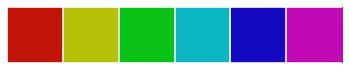

In [5]:
current_palette = sns.color_palette(sns.hls_palette(6, l=.4, s=.9))
sns.set_palette(current_palette)
sns.palplot(current_palette)
palette = itertools.cycle(sns.color_palette())

We use Alaska Albers shapefiles all around to be able to measure distances in metres. The WGS84 shapefiles from AICC and the Forest Service Active Fire Maps web portal were converted using GDAL: 

`ogr2ogr -f "ESRI Shapefile" outfile_AKAlbers.shp infile.shp -s_srs EPSG:4326 -t_SRS EPSG:3338` 

### Data loading - fire events as per management agencies & remotely sensed hotspots

Fire GIS data from AICC. (*NOTE:* The AK Albers Shapefile for fire locations was generated not directly from the WGS84 AICC shapefile. The latter was found to be somewhat corrupted with fields out of date. I first transformed it to JSON-WGS84 and then generated the AK Albers Shapefile from the JSON. Data thus generated looks consistent.)

In [6]:
firegis = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/AICC/"
firelocationdir = "2015_FireLocations"
firelocationshp = "2015FireLocations_AKAlbers.shp"
fireperimdir = "2015_FirePerimeters"
fireperimshp = "2015FirePerimeters_AKAlbers.shp"

In [7]:
perimcollection = fiona.open(os.path.join(firegis, fireperimdir, fireperimshp))
firecollection = fiona.open(os.path.join(firegis, firelocationdir, firelocationshp))

Active fire hotspots from activefiremaps.fs.fed.us:

In [8]:
firehotspots = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/activefiremaps.fs.fed.us_data_fireptdata/"
mod14dir = "modis_fire_2015_344_ak_shapefile"
mod14shp = "modis_fire_2015_344_ak_AKAlbers.shp"
viirsMdir = "viirs-af_fire_2015_344_ak_shapefile"
viirsMshp = "viirs-af_fire_2015_344_ak_AKAlbers.shp"
viirsIdir = "viirs_iband_fire_2015_344_ak_shapefile"
viirsIshp = "viirs_iband_fire_2015_344_ak_AKAlbers.shp"

In [9]:
mod14collection = fiona.open(os.path.join(firehotspots, mod14dir, mod14shp))
viirsMcollection = fiona.open(os.path.join(firehotspots, viirsMdir, viirsMshp))
viirsIcollection = fiona.open(os.path.join(firehotspots, viirsIdir, viirsIshp))

## Data inspection and pre-processing: AICC fire locations and fire perimeters 

In [10]:
print("Number of fire perimeters: {}".format(len(perimcollection)))
print("Number of fire locations: {}".format(len(firecollection)))

Number of fire perimeters: 334
Number of fire locations: 866


Examples of a fire location and the properties associated with a fire perimeter in their native format:

In [10]:
firecollection.next()

{'geometry': {'coordinates': [(256270.89944600372, 1304750.8763099073)],
  'type': 'MultiPoint'},
 'id': '0',
 'properties': OrderedDict([(u'ID', 0),
              (u'NAME', u'Werner Rd'),
              (u'FIRESEASON', u'2015'),
              (u'LASTUPDATE', u'2015/07/14'),
              (u'MGMTORGID', u'DOF'),
              (u'MGMTOFFICE', u'MSS'),
              (u'MGMTOPTION', u'Critical'),
              (u'PRESCRIBED', None),
              (u'LATITUDE', 61.637),
              (u'LONGITUDE', -149.145033),
              (u'MAPNAME', u'Anchorage C-6'),
              (u'MAPNUMBER', None),
              (u'NEARESTWEA', None),
              (u'ORIGINOWNE', u'Private'),
              (u'ORIGINADMI', u'AKPRI-Private'),
              (u'DISCOVERYD', u'2015/01/08'),
              (u'DISCOVERYS', 2.0),
              (u'IADATETIME', None),
              (u'IASIZE', 0.0),
              (u'INITIALBEH', u'Rank 1'),
              (u'CONTROLDAT', u'2015/01/08'),
              (u'OUTDATE', u'2015/01/

In [11]:
print(json.dumps(perimcollection.next()["properties"], indent=2))

{
  "FireName": "Stuart Inert", 
  "Acres": 743.5, 
  "AFSFire#": "JP1V", 
  "DOFFire#": null, 
  "USFSFire#": "PDJP1V", 
  "Add#": "1500", 
  "Latest": "Yes", 
  "Date": "2015-05-06", 
  "EditDate": "2015-05-06", 
  "AgencyAcre": 743.5, 
  "Method": null, 
  "Sequence#": "075"
}


To join fire perimeters with fire locations (that is, find the appropriate perimeter, if it exists, for a fire event, we need an appropriate unique identifier that is consistently present. Ultimately, we can use the AFSFire ID. First, however, we investigate duplicate fire names. As it turns out:

 * fires with identical names still represent distinct events
 * *most* fires that are false alarms have the FALSEALARM property set to something that is not `none`. 
 * otherwise, fires that have no AFS ID seem to be either false alarms or otherwise very small transient fires
 
 To show the above, I first deduplicate both the fire event and the fire perimeter collection and inspect the names of fires that appear more than once. 

In [12]:
dedupfires = collections.Counter([item["properties"]["NAME"] for item in firecollection]) 
dedupperims = collections.Counter([item["properties"]["FireName"] for item in perimcollection])

In [13]:
repeatfires = [item for item in list(dedupfires) if dedupfires[item] > 1]
repeatperims = [item for item in list(dedupperims) if dedupperims[item] > 1]

In [14]:
print(dedupfires.most_common(15))
print(dedupperims.most_common(5))

[(u'Moose Creek', 4), (u'False Alarm #1', 3), (u'False Alarm #3', 3), (u'False Alarm 1', 3), (u'Sunrise', 2), (u'Windy Creek', 2), (u'West Fork', 2), (u'Long Lake', 2), (u'Wolverine', 2), (u'False Alarm #4', 2), (u'False Alarm #2', 2), (u'Dry Creek', 2), (u'Trail Creek', 2), (u'Bonanza', 2), (u'Crooked Creek', 2)]
[(u'West Fork', 2), (u'Kwethluk River # 2', 1), (u'Minnesota Creek', 1), (u'Chikululnuk', 1), (u'Bridge', 1)]


As we can see above, most fire events that are duplicates have names that start with "False Alarm". However, there's also four distinct items named "Moose Creek", so we'll have to see if the two fire perimeters called West Fork are distinct as well and can be deduped via the AFS ID. 

In [15]:
checkfirenames = []
for fire in firecollection:
    if fire["properties"]["NAME"] in repeatfires:
        newfire = {}
        newfire["ID"] = fire["properties"]["ID"]
        newfire["NAME"] = fire["properties"]["NAME"]
        newfire["LATITUDE"] = fire["properties"]["LATITUDE"]
        newfire["LONGITUDE"] = fire["properties"]["LONGITUDE"]
        newfire["AFSNUMBER"] = fire["properties"]["AFSNUMBER"]
        newfire["DOFNUMBER"] = fire["properties"]["DOFNUMBER"]
        newfire["USFSNUMBER"] = fire["properties"]["USFSNUMBER"]
        newfire["ACTUALTOTA"] = fire["properties"]["ACTUALTOTA"]
        newfire["DISCOVERYD"] = fire["properties"]["DISCOVERYD"]
        newfire["FALSEALARM"] = fire["properties"]["FALSEALARM"]
        checkfirenames.append(newfire)

print(json.dumps(sorted(checkfirenames, key=lambda k: k["NAME"]), indent=2))
            

[
  {
    "DOFNUMBER": "511283", 
    "NAME": "Bonanza", 
    "FALSEALARM": null, 
    "DISCOVERYD": "2015/06/14", 
    "AFSNUMBER": "JSM9", 
    "USFSNUMBER": null, 
    "LONGITUDE": -148.303166, 
    "ACTUALTOTA": 0.1, 
    "LATITUDE": 64.705, 
    "ID": 288
  }, 
  {
    "DOFNUMBER": "511394", 
    "NAME": "Bonanza", 
    "FALSEALARM": null, 
    "DISCOVERYD": "2015/06/20", 
    "AFSNUMBER": "JTB6", 
    "USFSNUMBER": "PNJTB6", 
    "LONGITUDE": -148.417722, 
    "ACTUALTOTA": 2.0, 
    "LATITUDE": 64.732055, 
    "ID": 400
  }, 
  {
    "DOFNUMBER": "503017", 
    "NAME": "Crooked Creek", 
    "FALSEALARM": null, 
    "DISCOVERYD": "2015/04/13", 
    "AFSNUMBER": null, 
    "USFSNUMBER": null, 
    "LONGITUDE": -151.270527, 
    "ACTUALTOTA": 0.1, 
    "LATITUDE": 60.271555, 
    "ID": 17
  }, 
  {
    "DOFNUMBER": "514505", 
    "NAME": "Crooked Creek", 
    "FALSEALARM": "Y", 
    "DISCOVERYD": "2015/06/21", 
    "AFSNUMBER": null, 
    "USFSNUMBER": null, 
    "LONGITUDE": -147.

The above is very reassuring: if we exclude the events that have FALSEALARM set or don't have an AFS ID, we should be good and have a list of deduplicated non-false-alarm fire events. Identical names can happen, but both lat/lon and AFS ID are distinct. 

Now we also have to check the fire perimeters. The expected result is that the two called West Fork are indeed separate, with AFS IDs of JS8Z and JT7T.

In [16]:
checkfireperims = []
for fire in perimcollection:
    if fire["properties"]["FireName"] in repeatperims:
        newfire = {}
        newfire["AFSFire#"] = fire["properties"]["AFSFire#"]
        newfire["FireName"] = fire["properties"]["FireName"]
        newfire["Date"] = fire["properties"]["Date"]
        newfire["Sequence#"] = fire["properties"]["Sequence#"]
        checkfireperims.append(newfire)

print(json.dumps(sorted(checkfireperims, key=lambda k: k["FireName"]), indent=2))


[
  {
    "Date": "2015-06-28", 
    "AFSFire#": "JT7T", 
    "FireName": "West Fork", 
    "Sequence#": "613"
  }, 
  {
    "Date": "2015-09-01", 
    "AFSFire#": "JS8Z", 
    "FireName": "West Fork", 
    "Sequence#": "363"
  }
]


Initially, I wanted to remove the false alarms and those fires that have no AFS ID. However, this would remove nearly 300 fire events, some of which (a minority) of substantial size. Putting it all together, I define a filter function to apply to the fire event collection to remove the false alarms *only*:

In [18]:
def not_false_alarms(record):
    return not record["properties"]["FALSEALARM"]

fireeventcollection = filter(not_false_alarms, firecollection)

In [19]:
len(fireeventcollection)

781

Now let's look if there are fire perimeters for which we can't find a fire event. Turns out, there is one:

In [20]:
fireeventnames = set([record["properties"]["NAME"] for record in fireeventcollection])
fireperimnames = set([record["properties"]["FireName"] for record in perimcollection])

In [21]:
fireperimnames.difference(fireeventnames)

{u'Scow Harry # 2.'}

The plan is now the following: First create a unified fire ID from AFS/DOF/USFS ID (checking that every fire perimeter has at least one of these [which will turn out to be the case). Then loop through the fire perimeter collection and check if every fire was detected by a hotspot. Keep track which fire was visited, by name, size and unified ID number. Join in other desided properties from the fire events dataset.

That should work for all except Scow Harry # 2, whose name seems to be different in both dataset. We'll just correct the name to one version.

In a later step we cen cycle through the rest of the fire events. This is somewhat sub-optimal as we didn't operate a full join between the two data sets, the main impact of which is that the fires that only have a perimeter are lacking a start date. This is to be addressed later. 

## Data inspection: fire hotspots from activefiremaps.fs.fed.us 

We can see that for the fire hotspot data, the coordinates under the `geometry` have been translated to Alaska Albers, but the original latitude and longitude remain available under `properties`. 

The properties SPIX and TPIX refer to the approximate extent of the pixel (in km) in scan and in track direction. I can use these to derive a footprint. However, we don't know the alignment of scan and track directions relative to north. There are various ways around this problem:

 * pretend scan direction is E-W and track direction is N-S
 * take an average of the two and define a circle that has the same area
 * (what I will do as a first instance) use a circle with a radius that is half the diagonal of the scan/track rectangle 

In [22]:
print(json.dumps(mod14collection.next(), indent=2))

{
  "geometry": {
    "type": "Point", 
    "coordinates": [
      209006.9285980303, 
      2268502.3384028086
    ]
  }, 
  "type": "Feature", 
  "id": "0", 
  "properties": {
    "AREA": 0.0, 
    "PERIMETER": 0.0, 
    "FIRE_": 1.0, 
    "FIRE_ID": 556152.0, 
    "LAT": 70.32, 
    "LONG": -148.538, 
    "DATE": "2015-08-25", 
    "JULIAN": 237, 
    "GMT": 548, 
    "TEMP": 302.8, 
    "SPIX": 1.5, 
    "TPIX": 1.2, 
    "SRC": "uaf", 
    "SAT_SRC": "T", 
    "CONF": 51, 
    "FRP": 18.5
  }
}


In [23]:
print(json.dumps(viirsMcollection.next(), indent=2))

{
  "geometry": {
    "type": "Point", 
    "coordinates": [
      159682.16772669667, 
      2274023.377251573
    ]
  }, 
  "type": "Feature", 
  "id": "0", 
  "properties": {
    "AREA": 0.0, 
    "PERIMETER": 0.0, 
    "FIRE_": 1.0, 
    "FIRE_ID": 96264.0, 
    "LAT": 70.403, 
    "LONG": -149.814, 
    "DATE": "2015-06-20", 
    "JULIAN": 171, 
    "GMT": 2131, 
    "TEMP": 306.9, 
    "SPIX": 0.8, 
    "TPIX": 0.7, 
    "SRC": "uaf", 
    "SAT_SRC": "S-NPP", 
    "CONF": 0, 
    "FRP": 4.8
  }
}


VIIRS I-band hotspots don't appear to have pixel dimensions.

In [24]:
print(json.dumps(viirsIcollection.next(), indent=2))

{
  "geometry": {
    "type": "Point", 
    "coordinates": [
      209193.49611854053, 
      2269427.470214345
    ]
  }, 
  "type": "Feature", 
  "id": "0", 
  "properties": {
    "AREA": 0.0, 
    "PERIMETER": 0.0, 
    "FIRE_": 1.0, 
    "FIRE_ID": 705023.0, 
    "LAT": 70.328, 
    "LONG": -148.531, 
    "DATE": "2015-09-03", 
    "JULIAN": 246, 
    "GMT": 1132, 
    "BT4TEMP": 295.6, 
    "BT5TEMP": 273.4, 
    "SRC": "rsac", 
    "SAT_SRC": "S-NPP", 
    "CONF": "Nominal"
  }
}


In [25]:
len(mod14collection)

26670

In [26]:
len(viirsMcollection)

34224

In [27]:
len(viirsIcollection)

54677

## Generating a unified, pre-processed fire perimeter dataset using Pandas/GeoPandas

In [28]:
import geopandas as gp
import pandas as pd

In [29]:
fireperimDF = gp.GeoDataFrame.from_file(os.path.join(firegis, fireperimdir, fireperimshp))
firelocDF = gp.GeoDataFrame.from_file(os.path.join(firegis, firelocationdir, firelocationshp))
fireeventDF = firelocDF[firelocDF.FALSEALARM.isnull()]

We keep a list of columns that we want to use later, potentially, in order to reduce the fire event dataset. Also, we remove from the fire event dataset the ones that are marked as false alarms, which reduces the number from 866 to 781. 

In [30]:
fireloccolumns  = ['NAME', 'ACTUALTOTA', 'AFSNUMBER', 'USFSNUMBER', 'DOFNUMBER', 'FALSEALARM', 'ESTIMATEDT', 'GENERALCAU', 'PRIMARYFUE']

In [31]:
fireeventDF.head()
print(len(fireeventDF))

781


The fire datasets use three different ID numbers (AFSID, USFSID, DOFID), depending on whether the Alaska Fire Service, the US Forest Service or the AK Department of Forestry are responsible for it. Some fires have multiple IDs. In order to be able to use these IDs to merge the fire perimeter dataset with the dataset of fire events, we need to check two things: a) If a fire perimeter has a particular ID type, its corresponding fire location also has the same ID. b) Which of the three ID types is the most common, and which is the least common?

In [32]:
numperims = len(fireperimDF)
numfires = len(fireeventDF)
print("Total number of fire perimeters: {}".format(numperims))
print("Number of fire perimeters with AFS ID: {}".format(numperims - sum(fireperimDF['AFSFire#'].isnull())))
print("Number of fire perimeters with DOF ID: {}".format(numperims - sum(fireperimDF['DOFFire#'].isnull())))
print("Number of fire perimeters with USFS ID: {}".format(numperims - sum(fireperimDF['USFSFire#'].isnull())))
print()
print("Total number of fire events: {}".format(numfires))
print("Number of fire perimeters with AFS ID: {}".format(numfires - sum(fireeventDF['AFSNUMBER'].isnull())))
print("Number of fire perimeters with DOF ID: {}".format(numfires - sum(fireeventDF['DOFNUMBER'].isnull())))
print("Number of fire perimeters with USFS ID: {}".format(numfires - sum(fireeventDF['USFSNUMBER'].isnull())))

Total number of fire perimeters: 334
Number of fire perimeters with AFS ID: 295
Number of fire perimeters with DOF ID: 204
Number of fire perimeters with USFS ID: 126

Total number of fire events: 781
Number of fire perimeters with AFS ID: 539
Number of fire perimeters with DOF ID: 595
Number of fire perimeters with USFS ID: 248


There is one fire perimeter that has a USFS Fire ID, but with no fire location that has the same USFS ID:

In [33]:
print("Number of fire perimeters whose AFS ID is in the fire event dataset: {}".format(
    sum(~fireperimDF['AFSFire#'].isnull() & fireperimDF['AFSFire#'].isin(fireeventDF['AFSNUMBER']))))
print("Number of fire perimeters whose USFS ID is in the fire event dataset: {}".format(
    sum(~fireperimDF['USFSFire#'].isnull() & fireperimDF['USFSFire#'].isin(fireeventDF['USFSNUMBER']))))
print("Number of fire perimeters whose DOF ID is in the fire event dataset: {}".format(
    sum(~fireperimDF['DOFFire#'].isnull() & fireperimDF['DOFFire#'].isin(fireeventDF['DOFNUMBER']))))

Number of fire perimeters whose AFS ID is in the fire event dataset: 295
Number of fire perimeters whose USFS ID is in the fire event dataset: 125
Number of fire perimeters whose DOF ID is in the fire event dataset: 204


As it turns out, this fire *does* have a USFS ID in both datasets, but one of them is PDJV2T and the other is PNJV2T. The same fire has both an ASF ID and a DOF ID. 

In [34]:
fireperimDF[~fireperimDF['USFSFire#'].isnull() & ~fireperimDF['USFSFire#'].isin(fireeventDF['USFSNUMBER'])]

,AFSFire#,Acres,Add#,AgencyAcre,DOFFire#,Date,EditDate,FireName,Latest,Method,Sequence#,USFSFire#,geometry
80,JV2T,90.7,51,90.6,504490,2015-06-28,2015-07-02,Canadian Creek,Yes,None,490,PDJV2T,POLYGON ((-114909.2894434733 1461329.738132251...


In [35]:
firelocDF[fireloccolumns][firelocDF.AFSNUMBER == 'JV2T']

,NAME,ACTUALTOTA,AFSNUMBER,USFSNUMBER,DOFNUMBER,FALSEALARM,ESTIMATEDT,GENERALCAU,PRIMARYFUE
483,Canadian Creek,90,JV2T,PNJV2T,504490,None,90,Lightning,Mixed (Hardwoods/Softwoods)


In order to normalise the dataset, we pick one:

In [36]:
firelocDF.set_value(firelocDF.AFSNUMBER == 'JV2T', 'USFSNUMBER', 'PDJV2T')

,ACTUALTOTA,ADDITIONAL,ADSPERMISS,AFSNUMBER,AREA,BURNEDOVER,BURNEDOV_1,CARRYOVER,COMPLEX,COMPLEXPAR,...,TYPE1ASSIG,TYPE1RELEA,TYPE2ASSIG,TYPE2RELEA,USFSNUMBER,WFUFIRE,WIDTHOFFRO,WINDDIRECT,WINDSPEEDM,geometry
0,2.0,None,DEFAULT,None,0,None,None,None,None,None,...,None,None,None,None,None,None,0,None,0,(POINT (256270.8994460037 1304750.876309907))
1,0.0,None,DEFAULT,JJP6,0,None,None,None,None,None,...,None,None,None,None,None,None,0,None,0,(POINT (265118.3298718085 1719083.99314185))
2,0.1,None,DEFAULT,None,0,None,None,None,None,None,...,None,None,None,None,None,None,0,None,0,(POINT (260182.4219830227 1301363.066134626))
3,0.2,None,DEFAULT,None,0,None,None,None,None,None,...,None,None,None,None,None,None,0,None,0,(POINT (262634.8608243892 1294648.762179792))
4,0.3,None,DEFAULT,None,0,None,None,None,None,None,...,None,None,None,None,None,None,0,None,0,(POINT (247811.8430938913 1300441.794910402))
5,0.1,None,DEFAULT,None,0,None,None,None,None,None,...,None,None,None,None,None,None,0,None,0,(POINT (233023.2082102441 1300592.819771728))
6,0.1,None,DEFAULT,None,0,None,None,None,None,None,...,None,None,None,None,None,None,0,None,0,(POINT (249739.9234720697 1299663.006937216))
7,0.4,None,DEFAULT,None,0,None,None,None,None,None,...,None,None,None,None,None,None,0,None,0,(POINT (253199.5756644921 1283033.922523989))
8,0.2,None,DEFAULT,None,0,None,None,None,None,None,...,None,None,None,None,None,None,0,None,0,(POINT (241504.1653921472 1303463.423596077))
9,0.1,None,DEFAULT,None,0,None,None,None,None,None,...,None,None,None,None,None,None,0,None,0,(POINT (252664.5427840402 1301532.15409474))


In [37]:
firelocDF[fireloccolumns][firelocDF.AFSNUMBER == 'JV2T']

,NAME,ACTUALTOTA,AFSNUMBER,USFSNUMBER,DOFNUMBER,FALSEALARM,ESTIMATEDT,GENERALCAU,PRIMARYFUE
483,Canadian Creek,90,JV2T,PDJV2T,504490,None,90,Lightning,Mixed (Hardwoods/Softwoods)


Furthermore, every fire perimeter has either an AFS or a DOF ID, and only 9 fire events have a USFS ID only:

In [38]:
print("Number of fire perimeters with DOF ID or AFS ID: {}".format(
    sum(~fireperimDF['DOFFire#'].isnull() |  ~fireperimDF['AFSFire#'].isnull())))
print("Number of fire events with DOF ID or AFS ID: {}".format(
    sum(~fireeventDF['DOFNUMBER'].isnull() |  ~fireeventDF['AFSNUMBER'].isnull())))

Number of fire perimeters with DOF ID or AFS ID: 334
Number of fire events with DOF ID or AFS ID: 772


We also need to clean up one fire name that has a final period in the perimeter, but not in the location database:

In [39]:
firelocDF[fireloccolumns].loc[firelocDF['NAME'].str.startswith('Scow Harry ')]

,NAME,ACTUALTOTA,AFSNUMBER,USFSNUMBER,DOFNUMBER,FALSEALARM,ESTIMATEDT,GENERALCAU,PRIMARYFUE
368,Scow Harry Creek,1,JS81,PNJS81,504352,None,1,Lightning,Live White Spruce
606,Scow Harry # 2,4250,JY2T,PNJY2T,504614,None,4250,Lightning,Black Spruce


In [40]:
firelocDF.NAME[firelocDF['DOFNUMBER'] == '504614']

606    Scow Harry # 2
Name: NAME, dtype: object

In [41]:
fireperimDF.loc[fireperimDF['FireName'].str.startswith('Scow Harry ')]

,AFSFire#,Acres,Add#,AgencyAcre,DOFFire#,Date,EditDate,FireName,Latest,Method,Sequence#,USFSFire#,geometry
308,None,4249.7,None,0,504614,2015-07-13,2015-07-14,Scow Harry # 2.,Yes,None,614,None,POLYGON ((-22908.27588810034 1480419.970181071...


In [42]:
fireperimDF.set_value(fireperimDF['DOFFire#']=='504614', 'FireName', "Scow Harry # 2")
fireperimDF.loc[fireperimDF['DOFFire#']=='504614'].FireName

308    Scow Harry # 2
Name: FireName, dtype: object

Now we create a cleaned, shared ID column that uniquely identifies a fire (as long as it is part of both datasets) across the two datasets.

In [43]:
cleanedfireperimDF = fireperimDF[['Acres', 'AgencyAcre', 'Date', 'FireName', 'geometry']]

cleanedfireperimDF.loc[:, 'cleanedID'] = pd.Series(
    [item1 if (item1 and item1 in fireeventDF["AFSNUMBER"].values) 
        else (item2 if item2 and item2 in fireeventDF["USFSNUMBER"].values
          else item3) 
        for item1, item2, item3 in 
        zip(fireperimDF.loc[:,'AFSFire#'], fireperimDF.loc[:,'USFSFire#'], fireperimDF.loc[:,'DOFFire#'])],
    index=cleanedfireperimDF.index)

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [44]:
fireeventDF.loc[:, 'cleanedID'] = pd.Series(
    [item1 if (item1 and item1 in fireperimDF["AFSFire#"].values) 
        else (item2 if item2 and item2 in fireperimDF["USFSFire#"].values
          else item3) 
        for item1, item2, item3 in 
        zip(fireeventDF.loc[:,'AFSNUMBER'], fireeventDF.loc[:,'USFSNUMBER'], fireeventDF.loc[:,'DOFNUMBER'])],
            index=fireeventDF.index)

In [45]:
keepeventcolumns = ['AREA', 'CONTROLDAT', 'DISCOVERYD', 'ESTIMATEDT', 'FALSEALARM', 'FIREBEHAVI', 'GENERALCAU', 
 'LATITUDE', 'LONGITUDE', 'MGMTOPTION', 'NAME', 'OUTDATE', 'PRIMARYFUE', 'STRUCTURES', 'cleanedID', 'AFSNUMBER', 'DOFNUMBER', 'USFSNUMBER']

In [46]:
cleanedfireperimDF = pd.merge(cleanedfireperimDF, fireeventDF[keepeventcolumns], how='left', on='cleanedID')
cleanedfireperimDF.geometry = cleanedfireperimDF.geometry.astype(gp.geoseries.GeoSeries)

### Inspecting the cleaned perimeter dataset, and last adjustments

Here is the reason I kept these columns. I'll change the case of the management options... 

In [47]:
cleanedfireperimDF['PRIMARYFUE'].value_counts()

Black Spruce                   204
Other                           41
Grass                           28
Mixed (Hardwoods/Softwoods)     17
Unknown                         15
Tundra                          14
Mixed Trees                     11
Hardwoods                        2
White Spruce                     1
Live White Spruce                1
Name: PRIMARYFUE, dtype: int64

In [48]:
cleanedfireperimDF['FIREBEHAVI'].value_counts()

Running       86
Creeping      74
Smoldering    44
Crowning       1
Name: FIREBEHAVI, dtype: int64

We also need to ensure spelling of the properties is normalised:

In [49]:
cleanedfireperimDF['MGMTOPTION'].value_counts()
cleanedfireperimDF.loc[:, 'MGMTOPTION'] =  cleanedfireperimDF['MGMTOPTION'].str.capitalize()

In [50]:
cleanedfireperimDF['MGMTOPTION'].value_counts()

Limited       207
Full           75
Modified       42
Critical        6
Prescribed      4
Name: MGMTOPTION, dtype: int64

In [51]:
cleanedfireperimDF['GENERALCAU'].value_counts()

Lightning     302
Human          27
Prescribed      5
Name: GENERALCAU, dtype: int64

In [52]:
cleanedfireperimDF.sort_values(by="Acres", ascending=False).head(n=10)

,Acres,AgencyAcre,Date,FireName,geometry,cleanedID,AREA,CONTROLDAT,DISCOVERYD,ESTIMATEDT,...,LATITUDE,LONGITUDE,MGMTOPTION,NAME,OUTDATE,PRIMARYFUE,STRUCTURES,AFSNUMBER,DOFNUMBER,USFSNUMBER
265,312918.2,0,2015-08-14,Big Creek Two,(POLYGON ((-20882.26378179465 1607549.50705177...,JT00,0,2015/09/29,2015/06/22,312918.2,...,64.734333,-155.009000,Limited,Big Creek Two,2015/09/29,Black Spruce,0,JT00,532533,PDJT00
134,276038.2,0,2015-09-01,Sushgitit Hills,(POLYGON ((41658.08829758948 1775828.751329678...,JTH3,0,2015/09/29,2015/06/21,276038.2,...,66.032305,-153.022305,Limited,Sushgitit Hills,2015/09/29,Black Spruce,0,JTH3,532449,PDJTH3
232,223154.1,0,2015-09-06,Holtnakatna,(POLYGON ((-86871.17625220573 1705641.89515390...,JT05,0,2015/09/10,2015/06/22,223154.1,...,65.184333,-156.214833,Limited,Holtnakatna,2015/09/10,Mixed Trees,0,JT05,532539,PDJT05
222,149359.3,0,2015-09-09,Isahultila,(POLYGON ((-39240.57997349499 1788911.75379671...,JTP9,0,2015/09/28,2015/06/21,149359.3,...,65.869388,-154.681083,Modified,Isahultila,2015/09/28,Black Spruce,0,JTP9,532471,PDJTP9
133,142650.4,0,2015-08-31,Rock,(POLYGON ((11033.23273654767 1803603.367652406...,JS7U,0,2015/09/29,2015/06/19,142650.4,...,66.000444,-153.999944,Full,Rock,2015/09/29,Black Spruce,0,JS7U,532336,PDJS7U
205,121339.2,0,2015-07-29,Blazo,POLYGON ((-172586.9596935369 1524230.302354595...,JS8X,0,2015/09/28,2015/06/19,121339.2,...,63.418333,-157.611166,Limited,Blazo,2015/09/28,Black Spruce,0,JS8X,532362,PDJS8X
292,112806.8,0,2015-08-31,Bering Creek,(POLYGON ((27572.15926924982 1665405.933977257...,JTQ7,0,2015/09/29,2015/06/21,112806.8,...,64.983333,-153.550000,Limited,Bering Creek,2015/09/29,Black Spruce,0,JTQ7,None,None
124,111193.9,0,2015-07-31,Sea,(POLYGON ((20847.26522161979 1575923.416614742...,JS82,0,2015/09/29,2015/06/19,111193.8,...,64.100000,-153.733333,Limited,Sea,2015/09/29,Grass,0,JS82,None,PDJS82
226,103967.5,0,2015-09-01,Big Mud River 1,(POLYGON ((37830.83615499216 1624708.370822584...,JTP5,0,2015/09/29,2015/06/21,103967.5,...,64.673666,-152.925833,Limited,Big Mud River 1,2015/09/29,Black Spruce,0,JTP5,None,None
288,100524.0,0,2015-09-01,Munsatli 2,(POLYGON ((61475.03156174919 1529359.671351367...,JWE2,0,2015/09/29,2015/07/04,100524.0,...,63.629166,-153.019166,Limited,Munsatli 2,2015/09/29,Black Spruce,0,JWE2,531703,None


Now let's plot a few of the largest ones

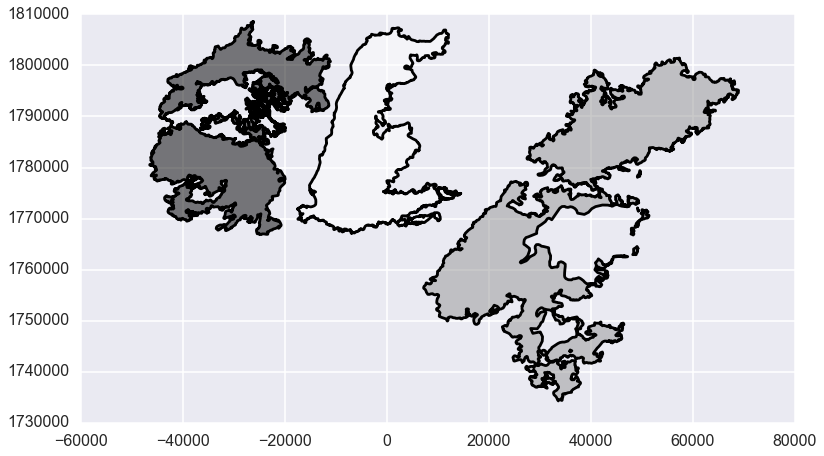

In [53]:
cleanedfireperimDF[cleanedfireperimDF.FireName.isin(['Sushgitit Hills', 'Rock', 'Isahultila', ])].plot()

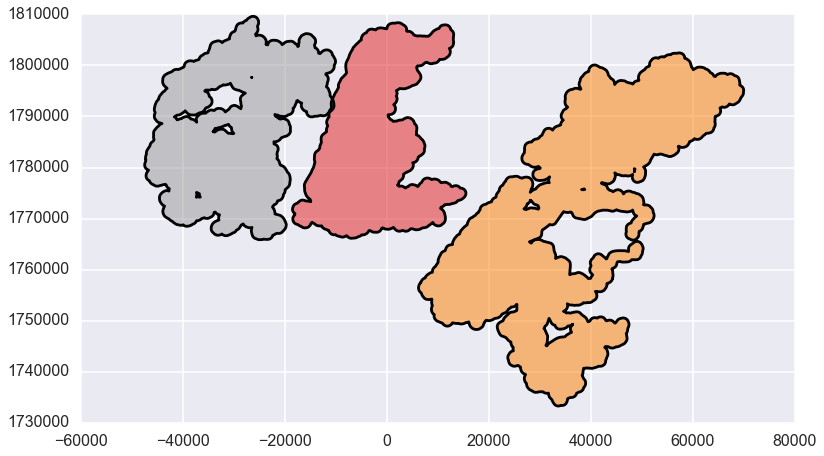

In [54]:
cleanedfireperimDF[cleanedfireperimDF.FireName.isin(['Sushgitit Hills', 'Rock', 'Isahultila', ])].geometry.buffer(1000).plot()

## Various exploratory code snippets to prepare spatial joining of perimeters with fire pixels

In [82]:
cleanedfireperimDF[['DISCOVERYD', 'CONTROLDAT', 'OUTDATE']].count()

DISCOVERYD    334
CONTROLDAT    325
OUTDATE       332
dtype: int64

In [69]:
mod14DF = gp.GeoDataFrame.from_file(os.path.join(firehotspots, mod14dir, mod14shp))
viirsMDF = gp.GeoDataFrame.from_file(os.path.join(firehotspots, viirsMdir, viirsMshp))
viirsIDF = gp.GeoDataFrame.from_file(os.path.join(firehotspots, viirsIdir, viirsIshp))

In [194]:
viirsMDF.head()

,AREA,CONF,DATE,FIRE_,FIRE_ID,FRP,GMT,JULIAN,LAT,LONG,PERIMETER,SAT_SRC,SPIX,SRC,TEMP,TPIX,geometry
0,0,0,2015-06-20,1,96264,4.8,2131,171,70.403,-149.814,0,S-NPP,0.8,uaf,306.9,0.7,POINT (159682.1677266967 2274023.377251573)
1,0,100,2015-06-19,2,93697,0.0,1017,170,68.111,-140.338,0,S-NPP,1.0,rsac,457.6,1.3,POINT (569369.973574263 2075474.842843879)
2,0,100,2015-06-19,3,93696,0.0,1017,170,68.110,-140.364,0,S-NPP,1.0,rsac,457.1,1.3,POINT (568324.2487185599 2075143.858433177)
3,0,100,2015-06-19,4,93695,0.0,1017,170,68.109,-140.390,0,S-NPP,1.0,rsac,456.7,1.3,POINT (567278.352047907 2074813.274240302)
4,0,100,2015-06-19,5,93693,0.0,1017,170,68.108,-140.442,0,S-NPP,1.0,rsac,459.9,1.3,POINT (565163.6192416191 2074261.618983614)


In [197]:
def comparewithrow(datestartakdt, dateendakdt=None):
    def timecomphelper(firerow):
        datetimestamp1 = dt.datetime.strptime(firerow['DATE'] + str(firerow['GMT']).zfill(4), "%Y-%m-%d%H%M") 
        datetimestamp1 -= dt.timedelta(hours=8)
        datetimestampstart = dt.datetime.strptime(datestartakdt, "%Y/%m/%d")
        if dateendakdt:
            datetimestampend = dt.datetime.strptime(dateendakdt, "%Y/%m/%d")
            return (datetimestamp1 >= datetimestampstart) & (datetimestamp1 <= datetimestampend)
        else:
            return datetimestamp1 >= datetimestampstart
    return timecomphelper

In [137]:
import rtree

spatialindex = rtree.index.Index()
for idx, record in cleanedfireperimDF[
    cleanedfireperimDF.FireName.isin(['Sushgitit Hills', 'Rock', 'Isahultila'])].iterrows():
       spatialindex.insert(idx, record.geometry.bounds)

In [160]:
spatialindex_buffered = rtree.index.Index()
for idx, record in cleanedfireperimDF[
    cleanedfireperimDF.FireName.isin(['Sushgitit Hills', 'Rock', 'Isahultila'])].iterrows():
       spatialindex_buffered.insert(idx, record.geometry.buffer(1000).bounds)

In [146]:
for idx, record in cleanedfireperimDF[cleanedfireperimDF.FireName.isin(['Sushgitit Hills', 'Rock', 'Isahultila', 'Big Mud River 1'])].iterrows():
    print(idx, record.FireName)

133 Rock
134 Sushgitit Hills
222 Isahultila
226 Big Mud River 1


It seems a spatial index is not worth the effort as it means we need to loop through the pixels first, and therefore operations get done over and over again on the permeters. 

In [159]:
for ii, firepixel in mod14DF.head(2700).iterrows():
    for jj in spatialindex.intersection(firepixel.geometry.coords[0]):
        currentperim = cleanedfireperimDF.loc[jj]
        if firepixel.geometry.within(currentperim.geometry):
            print('Firepoint {} at {}, {} detects {} on {}'.format(
                    firepixel.FIRE_ID, firepixel.LAT, firepixel.LONG, currentperim.FireName, firepixel.DATE))
    

Firepoint 492361.0 at 66.218, -153.962 detects Rock on 2015-08-07
Firepoint 492362.0 at 66.218, -153.962 detects Rock on 2015-08-07
Firepoint 492892.0 at 66.217, -154.605 detects Isahultila on 2015-08-08
Firepoint 490581.0 at 66.215, -153.965 detects Rock on 2015-08-06
Firepoint 480726.0 at 66.214, -153.978 detects Rock on 2015-07-26
Firepoint 480725.0 at 66.213, -154.013 detects Rock on 2015-07-26
Firepoint 492888.0 at 66.21, -154.635 detects Isahultila on 2015-08-08
Firepoint 183590.0 at 66.21, -154.036 detects Rock on 2015-07-25
Firepoint 480724.0 at 66.21, -153.999 detects Rock on 2015-07-26
Firepoint 183588.0 at 66.208, -154.032 detects Rock on 2015-07-25
Firepoint 480723.0 at 66.208, -154.016 detects Rock on 2015-07-26
Firepoint 484431.0 at 66.208, -153.989 detects Rock on 2015-07-31
Firepoint 480722.0 at 66.207, -154.021 detects Rock on 2015-07-26
Firepoint 480188.0 at 66.206, -154.067 detects Rock on 2015-07-25
Firepoint 480187.0 at 66.206, -154.035 detects Rock on 2015-07-25
F

In [167]:
mod14DF['timestamp'] = mod14DF.apply(lambda row: 
                dt.datetime.strptime(row.DATE + str(row.GMT).zfill(4), "%Y-%m-%d%H%M")
                + dt.timedelta(hours=8), axis=1)

In [169]:
cleanedfireperimDF['MOD14count'] = 0
for ii, firepixel in mod14DF.iterrows():
    for jj in spatialindex_buffered.intersection(firepixel.geometry.coords[0]):
        currentperim = cleanedfireperimDF.loc[jj]
        if firepixel.geometry.within(currentperim.geometry.buffer(1000)):
            if firepixel.timestamp >= dt.datetime.strptime(currentperim.DISCOVERYD, "%Y/%m/%d"):
                currentperim['MOD14count'] += 1 

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyboardInterrupt: 

In [207]:
for idx, record in cleanedfireperimDF[cleanedfireperimDF.FireName.isin(['Sushgitit Hills', 'Rock', 'Isahultila'])].iterrows():
    cleanedfireperimDF.loc[idx, 'MOD14count'] = 0
    timecomphelper = comparewithrow(record.DISCOVERYD, record.OUTDATE)
    buffered = record.geometry.buffer(1000)
    for pix, firepixel in mod14DF[mod14DF.apply(lambda row: timecomphelper(row), axis=1)].iterrows():
        if buffered.contains(firepixel.geometry):
            cleanedfireperimDF.loc[idx, 'MOD14count'] += 1
            mod14DF.loc[pix, 'infireperim'] = True
    print("{} - {} done".format(idx, record.FireName)) 

133 - Rock done
134 - Sushgitit Hills done
222 - Isahultila done


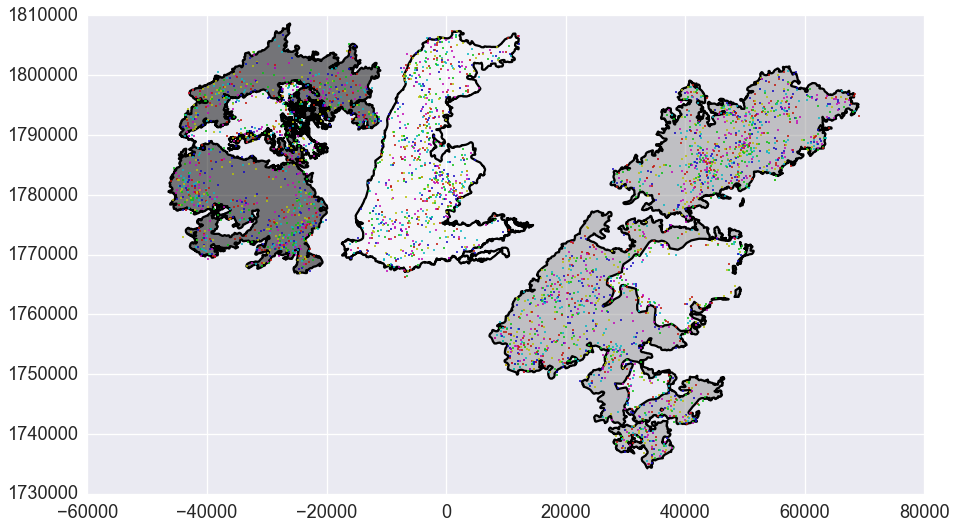

In [192]:
bmod14DF[mod14DF.infireperim].plot()

In [1]:
f = plt.figure(figsize=(15, 12))
ax1 = cleanedfireperimDF[cleanedfireperimDF.FireName.isin(['Sushgitit Hills', 'Rock', 'Isahultila', ])].plot()


NameError: name 'plt' is not defined

In [208]:
cleanedfireperimDF[cleanedfireperimDF.FireName.isin(['Sushgitit Hills', 'Rock', 'Isahultila', 'Big Mud River 1'])]

,Acres,AgencyAcre,Date,FireName,geometry,cleanedID,AREA,CONTROLDAT,DISCOVERYD,ESTIMATEDT,...,LONGITUDE,MGMTOPTION,NAME,OUTDATE,PRIMARYFUE,STRUCTURES,AFSNUMBER,DOFNUMBER,USFSNUMBER,MOD14count
133,142650.4,0,2015-08-31,Rock,(POLYGON ((11033.23273654767 1803603.367652406...,JS7U,0,2015/09/29,2015/06/19,142650.4,...,-153.999944,Full,Rock,2015/09/29,Black Spruce,0,JS7U,532336,PDJS7U,777
134,276038.2,0,2015-09-01,Sushgitit Hills,(POLYGON ((41658.08829758948 1775828.751329678...,JTH3,0,2015/09/29,2015/06/21,276038.2,...,-153.022305,Limited,Sushgitit Hills,2015/09/29,Black Spruce,0,JTH3,532449,PDJTH3,1846
222,149359.3,0,2015-09-09,Isahultila,(POLYGON ((-39240.57997349499 1788911.75379671...,JTP9,0,2015/09/28,2015/06/21,149359.3,...,-154.681083,Modified,Isahultila,2015/09/28,Black Spruce,0,JTP9,532471,PDJTP9,1050
226,103967.5,0,2015-09-01,Big Mud River 1,(POLYGON ((37830.83615499216 1624708.370822584...,JTP5,0,2015/09/29,2015/06/21,103967.5,...,-152.925833,Limited,Big Mud River 1,2015/09/29,Black Spruce,0,JTP5,None,None,644


In [204]:
sum(mod14DF.infireperim)

3673

## Pre-processing data frames of fire pixels

We'll also use GeoPandas for the purpose of processign the fire pixel files. 

In [55]:
mod14DF = gp.GeoDataFrame.from_file(os.path.join(firehotspots, mod14dir, mod14shp))
viirsMDF = gp.GeoDataFrame.from_file(os.path.join(firehotspots, viirsMdir, viirsMshp))
viirsIDF = gp.GeoDataFrame.from_file(os.path.join(firehotspots, viirsIdir, viirsIshp))

We add a column of type dt.datetime to the dataframes for easier access to the time stamp:

In [56]:
for df in [mod14DF, viirsMDF, viirsIDF]:
    df['timestamp_akdt'] = df.apply(lambda row: 
                dt.datetime.strptime(row.DATE + str(row.GMT).zfill(4), "%Y-%m-%d%H%M")
                - dt.timedelta(hours=8), axis=1)

Let's also define a time comparison helper function for later use:

In [201]:
def comparewithrow(datestartakdt, dateendakdt=None):
    def timecomphelper(firerow):
        datetimestamp1 = firerow['timestamp_akdt'] 
        datetimestampstart = dt.datetime.strptime(datestartakdt, "%Y/%m/%d")
        if dateendakdt:
            datetimestampend = dt.datetime.strptime(dateendakdt, "%Y/%m/%d")
            return (datetimestamp1 >= datetimestampstart) & (datetimestamp1 <= datetimestampend)
        else:
            return datetimestamp1 >= datetimestampstart
    return timecomphelper

## Cycling through fire perimeters and MOD14

First we set an extra column on each of the dataframes:

In [ ]:
mod14DF['infireperim'] = False
cleanedfireperimDF['MOD14count'] = 0

In [205]:
for idx, record in cleanedfireperimDF.iterrows():
    timecomphelper = comparewithrow(record.DISCOVERYD, record.OUTDATE)
    buffered = record.geometry.buffer(1000)
    for pix, firepixel in mod14DF[mod14DF.apply(lambda row: timecomphelper(row), axis=1)].iterrows():
        if buffered.contains(firepixel.geometry):
            cleanedfireperimDF.loc[idx, 'MOD14count'] += 1
            mod14DF.loc[pix, 'infireperim'] = True
    print("{} - {} done".format(idx, record.FireName))  

0 - Stuart Inert done
1 - CAL 1 done
2 - Bolgen Creek done
3 - Stuart Inert 2 done
4 - YTA Moose Creek RX 2015 done
5 - Little Montana Creek done
6 - Hickey Creek done
7 - Nikolai Slough done
8 - Machine done
9 - FWA Small Arms Complex RX 2015 done
10 - Little Swift Creek done
11 - DTAE Jarvis Creek RX 2015 done
12 - DTAE Wills SAC RX 2015 done
13 - Crater done
14 - North Fork done
15 - Sinona Creek done
16 - DMPTR 9 done
17 - Cal 4 done
18 - Kolmakof River done
19 - Sethkokna done
20 - West Fork done
21 - Bullion Creek done
22 - DTAE Bolio Lake Rx 2015 done
23 - Eagle Creek done
24 - DMPTR 7 done
25 - Black Lake done
26 - Ruby Slough done
27 - Little Creek done
28 - Red Devil done
29 - June Creek done
30 - Nushagak River done
31 - Juneau Lake done
32 - Yukon done
33 - Card Street done
34 - Apoon done
35 - Sockeye done
36 - Eldorado done
37 - Salmon River done
38 - Cummings Road done
39 - Stony done
40 - Buchahan done
41 - Copenhagen Creek done
42 - Kaghasuk Lake done
43 - Aropuk Lake 

How many fires were not detected? Further data inspection

In [210]:
print("Number of undetected fires: {}".format(sum(cleanedfireperimDF.MOD14count == 0)))
print(("Percentage of undetected fires: {:.2f}".format(100*sum(cleanedfireperimDF.MOD14count == 0)/len(cleanedfireperimDF))))
print(("Acreage of largest undetected fire: {}".format(max(cleanedfireperimDF.Acres[cleanedfireperimDF.MOD14count == 0]))))

Number of undetected fires: 77
Percentage of undetected fires: 23.05
Acreage of largest undetected fire: 3342.3


In [213]:
max(cleanedfireperimDF.MOD14count)

1846

In [268]:
print(sum(mod14DF.infireperim), sum(~mod14DF.infireperim), sum(~mod14DF.infireperim)/sum(mod14DF.infireperim))

25699 971 0.0377835713452


In [214]:
cleanedfireperimDF[cleanedfireperimDF.MOD14count==max(cleanedfireperimDF.MOD14count)]

,Acres,AgencyAcre,Date,FireName,geometry,cleanedID,AREA,CONTROLDAT,DISCOVERYD,ESTIMATEDT,...,LONGITUDE,MGMTOPTION,NAME,OUTDATE,PRIMARYFUE,STRUCTURES,AFSNUMBER,DOFNUMBER,USFSNUMBER,MOD14count
134,276038.2,0,2015-09-01,Sushgitit Hills,(POLYGON ((41658.08829758948 1775828.751329678...,JTH3,0,2015/09/29,2015/06/21,276038.2,...,-153.022305,Limited,Sushgitit Hills,2015/09/29,Black Spruce,0,JTH3,532449,PDJTH3,1846


In [215]:
cleanedfireperimDF[cleanedfireperimDF.FireName.str.startswith("Sockeye")]

,Acres,AgencyAcre,Date,FireName,geometry,cleanedID,AREA,CONTROLDAT,DISCOVERYD,ESTIMATEDT,...,LONGITUDE,MGMTOPTION,NAME,OUTDATE,PRIMARYFUE,STRUCTURES,AFSNUMBER,DOFNUMBER,USFSNUMBER,MOD14count
35,7264.9,7264.8,2015-07-04,Sockeye,(POLYGON ((203012.3694389864 1317671.666836289...,JSM8,0,2015/07/22,2015/06/14,7264.9,...,-150.085444,Full,Sockeye,2015/10/01,Mixed (Hardwoods/Softwoods),1455,JSM8,501282,PNJSM8,48


In [361]:
keepperimcols = list(cleanedfireperimDF.columns)
keepperimcols.remove('geometry')

In [362]:
print(keepperimcols)

[u'Acres', u'AgencyAcre', u'Date', u'FireName', 'cleanedID', u'AREA', u'CONTROLDAT', u'DISCOVERYD', u'ESTIMATEDT', u'FALSEALARM', u'FIREBEHAVI', u'GENERALCAU', u'LATITUDE', u'LONGITUDE', u'MGMTOPTION', u'NAME', u'OUTDATE', u'PRIMARYFUE', u'STRUCTURES', u'AFSNUMBER', u'DOFNUMBER', u'USFSNUMBER', 'MOD14count', 'VIIRSMcount', 'VIIRSIcount', 'blacksprucefire']


In [363]:
cleanedfireperimDF_forstats = cleanedfireperimDF[keepperimcols].copy()
type(cleanedfireperimDF_forstats)

pandas.core.frame.DataFrame

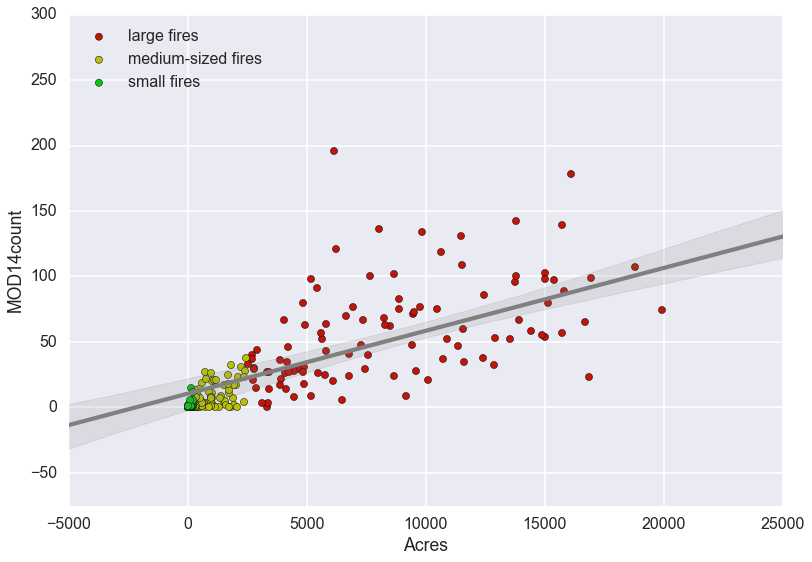

In [251]:
#f = plt.figure(figsize=(15, 12))

ax1 = cleanedfireperimDF_forstats[(cleanedfireperimDF_forstats.Acres > 2500) & (cleanedfireperimDF_forstats.Acres <= 20000 )].plot(
    kind='scatter', x='Acres', y="MOD14count", 
    s=50, label="large fires", color=next(palette))
cleanedfireperimDF_forstats[(cleanedfireperimDF_forstats.Acres <= 2500) & (cleanedfireperimDF_forstats.Acres > 250) ].plot(
    kind='scatter', x='Acres', y="MOD14count", 
    ax=ax1, s=50, label="medium-sized fires", 
    color=next(palette))
cleanedfireperimDF_forstats[(cleanedfireperimDF_forstats.Acres <= 250) ].plot(
    kind='scatter', x='Acres', y="MOD14count", 
    s=50, label="small fires", color=next(palette), ax=ax1)

sns.regplot(
    x="Acres", 
    y="MOD14count", 
    data=cleanedfireperimDF_forstats,
    ax=ax1,
    color="grey",
    scatter=False,
    line_kws={'zorder': 1}
    )
ax1.set_ylim((-75, 300))
ax1.legend(loc="upper left")

In [286]:
cleanedfireperimDF.groupby(["PRIMARYFUE"])["MOD14count"].mean()

PRIMARYFUE
Black Spruce                   104.700980
Grass                           26.392857
Hardwoods                        4.000000
Live White Spruce               96.000000
Mixed (Hardwoods/Softwoods)     44.882353
Mixed Trees                    118.818182
Other                           48.731707
Tundra                          41.000000
Unknown                         84.333333
White Spruce                    98.000000
Name: MOD14count, dtype: float64

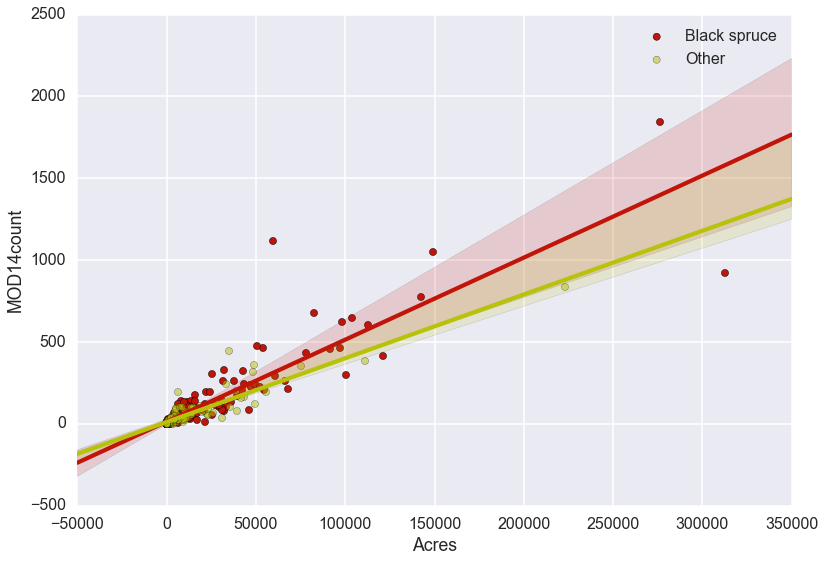

In [377]:
palette = itertools.cycle(sns.color_palette())
ax1 = cleanedfireperimDF_forstats[
    cleanedfireperimDF.PRIMARYFUE == "Black Spruce"].plot(
        kind='scatter', x='Acres', y="MOD14count", s=50, label="Black spruce", color=next(palette))
cleanedfireperimDF_forstats[
    cleanedfireperimDF.PRIMARYFUE != "Black Spruce"].plot(
        kind='scatter', x='Acres', y="MOD14count", ax=ax1, s=50, label="Other", color=next(palette), alpha=0.5)

palette = itertools.cycle(sns.color_palette())
sns.regplot(
    x="Acres", 
    y="MOD14count", 
    data=cleanedfireperimDF.loc[cleanedfireperimDF.blacksprucefire],
    ax=ax1,
    color=next(palette),
    scatter=False,
    line_kws={'zorder': 1}
    )
sns.regplot(
    x="Acres", 
    y="MOD14count", 
    data=cleanedfireperimDF.loc[~cleanedfireperimDF.blacksprucefire],
    ax=ax1,
    color=next(palette),
    scatter=False,
    line_kws={'zorder': 1}
    )

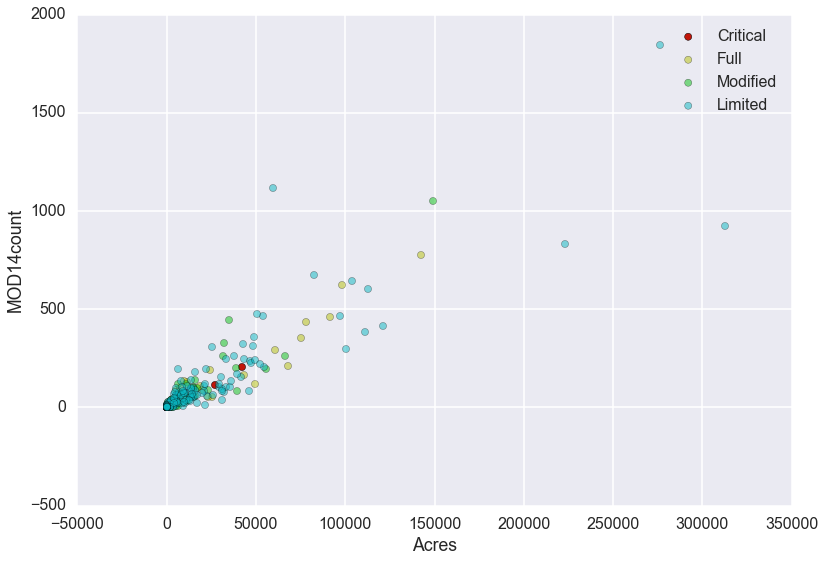

In [395]:
palette = itertools.cycle(sns.color_palette())
ax1 = cleanedfireperimDF_forstats[cleanedfireperimDF.MGMTOPTION == "Critical"].plot(kind='scatter', x='Acres', y="MOD14count", s=50, label="Critical", color=next(palette))
cleanedfireperimDF_forstats[cleanedfireperimDF.MGMTOPTION == "Full"].plot(kind='scatter', x='Acres', y="MOD14count", ax=ax1, s=50, label="Full", color=next(palette), alpha=0.5)
cleanedfireperimDF_forstats[cleanedfireperimDF.MGMTOPTION == "Modified"].plot(kind='scatter', x='Acres', y="MOD14count", ax=ax1, s=50, label="Modified", color=next(palette), alpha=0.5)
cleanedfireperimDF_forstats[cleanedfireperimDF.MGMTOPTION == "Limited"].plot(kind='scatter', x='Acres', y="MOD14count", ax=ax1, s=50, label="Limited", color=next(palette), alpha=0.5)


In [68]:
cleanedfireperimDF.groupby(["MGMTOPTION"])["MOD14pixelcount"].mean()

MGMTOPTION
Critical       53.333333
Full           72.310811
Limited        93.718447
Modified      101.075000
Prescribed      0.000000
Name: MOD14pixelcount, dtype: float64

In [69]:
cleanedfireperimDF.groupby(["MGMTOPTION"])["Acres"].mean()

MGMTOPTION
Critical      11613.550000
Full          13120.412162
Limited       16822.393204
Modified      15454.050000
Prescribed      686.000000
Name: Acres, dtype: float64

##  Now the same for VIIRS M-band

In [74]:
viirsMpoints = [shape(record["geometry"]) for record in viirsMcollection]

In [257]:
viirsMDF['infireperim'] = False
cleanedfireperimDF['VIIRSMcount'] = 0

In [258]:
for idx, record in cleanedfireperimDF.iterrows():
    timecomphelper = comparewithrow(record.DISCOVERYD, record.OUTDATE)
    buffered = record.geometry.buffer(1000)
    for pix, firepixel in viirsMDF[viirsMDF.apply(lambda row: timecomphelper(row), axis=1)].iterrows():
        if buffered.contains(firepixel.geometry):
            cleanedfireperimDF.loc[idx, 'VIIRSMcount'] += 1
            viirsMDF.loc[pix, 'infireperim'] = True
    print("{} - {} done".format(idx, record.FireName))  

0 - Stuart Inert done
1 - CAL 1 done
2 - Bolgen Creek done
3 - Stuart Inert 2 done
4 - YTA Moose Creek RX 2015 done
5 - Little Montana Creek done
6 - Hickey Creek done
7 - Nikolai Slough done
8 - Machine done
9 - FWA Small Arms Complex RX 2015 done
10 - Little Swift Creek done
11 - DTAE Jarvis Creek RX 2015 done
12 - DTAE Wills SAC RX 2015 done
13 - Crater done
14 - North Fork done
15 - Sinona Creek done
16 - DMPTR 9 done
17 - Cal 4 done
18 - Kolmakof River done
19 - Sethkokna done
20 - West Fork done
21 - Bullion Creek done
22 - DTAE Bolio Lake Rx 2015 done
23 - Eagle Creek done
24 - DMPTR 7 done
25 - Black Lake done
26 - Ruby Slough done
27 - Little Creek done
28 - Red Devil done
29 - June Creek done
30 - Nushagak River done
31 - Juneau Lake done
32 - Yukon done
33 - Card Street done
34 - Apoon done
35 - Sockeye done
36 - Eldorado done
37 - Salmon River done
38 - Cummings Road done
39 - Stony done
40 - Buchahan done
41 - Copenhagen Creek done
42 - Kaghasuk Lake done
43 - Aropuk Lake 

In [270]:
print("Number of undetected fires: {}".format(sum(cleanedfireperimDF.VIIRSMcount == 0)))
print(("Percentage of undetected fires: {:.2f}".format(100*sum(cleanedfireperimDF.VIIRSMcount == 0)/len(cleanedfireperimDF))))
print(("Acreage of largest undetected fire: {}".format(max(cleanedfireperimDF.Acres[cleanedfireperimDF.VIIRSMcount == 0]))))

Number of undetected fires: 96
Percentage of undetected fires: 28.74
Acreage of largest undetected fire: 25259.8


In [272]:
max(cleanedfireperimDF.VIIRSMcount)

896

In [274]:
print(sum(viirsMDF.infireperim), sum(~viirsMDF.infireperim), sum(~viirsMDF.infireperim)/len(viirsMDF))

11639 22585 0.659917017298


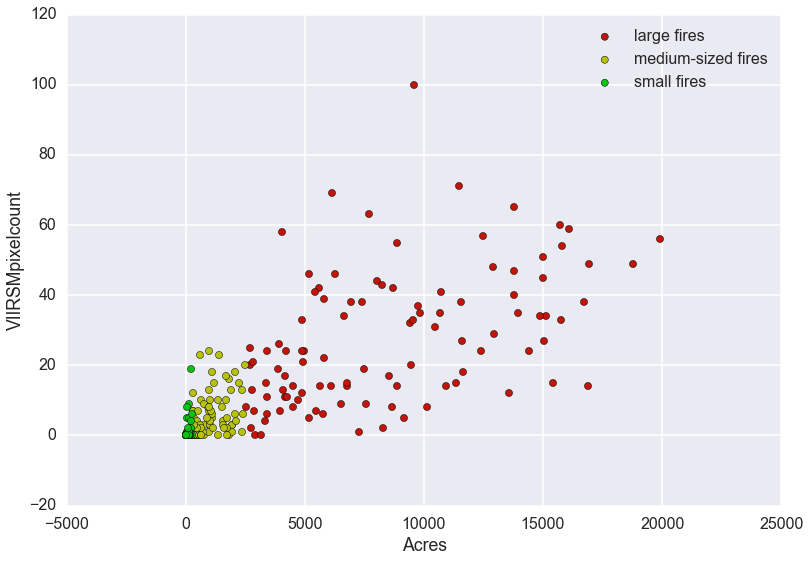

In [82]:
palette = itertools.cycle(sns.color_palette())
ax1 = cleanedfireperimDF[(cleanedfireperimDF.Acres > 2500) & (cleanedfireperimDF.Acres <= 20000 ) ].plot(kind='scatter', x='Acres', y="VIIRSMcount", s=50, label="large fires", color=next(palette))
cleanedfireperimDF[(cleanedfireperimDF.Acres <= 2500) & (cleanedfireperimDF.Acres > 250) ].plot(kind='scatter', x='Acres', y="VIIRSMcount", ax=ax1, s=50, label="medium-sized fires", color=next(palette))
cleanedfireperimDF[(cleanedfireperimDF.Acres <= 250) ].plot(kind='scatter', x='Acres', y="VIIRSMcount", s=50, label="small fires", color=next(palette), ax=ax1)

In [84]:
cleanedfireperimDF.groupby(["PRIMARYFUE"])["VIIRSMpixelcount"].mean()

PRIMARYFUE
Black Spruce                   56.222772
Grass                          12.428571
Hardwoods                       3.500000
Live White Spruce              47.000000
Mixed (Hardwoods/Softwoods)    14.937500
Mixed Trees                    84.818182
Other                          22.575000
Tundra                         19.785714
Unknown                        59.066667
White Spruce                   46.000000
Name: VIIRSMpixelcount, dtype: float64

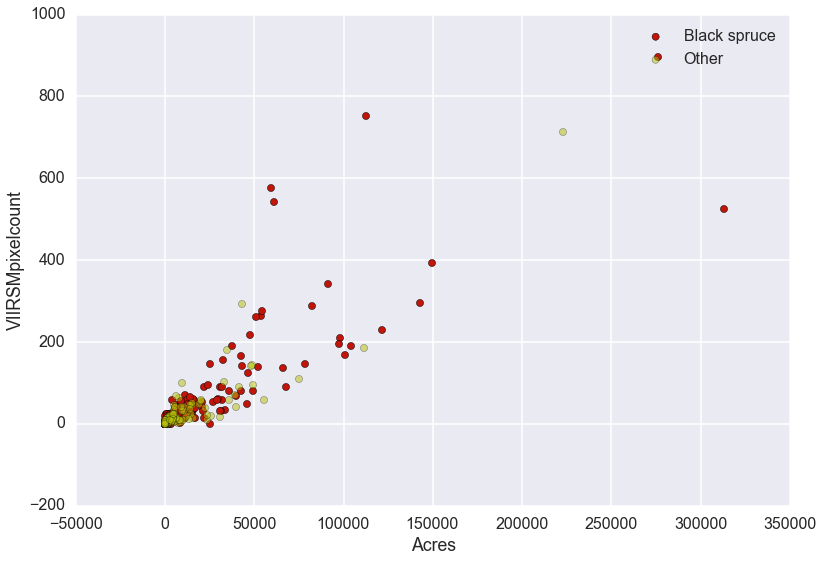

In [85]:
palette = itertools.cycle(sns.color_palette())
ax1 = cleanedfireperimDF[cleanedfireperimDF.PRIMARYFUE == "Black Spruce"].plot(kind='scatter', x='Acres', y="VIIRSMpixelcount", s=50, label="Black spruce", color=next(palette))
cleanedfireperimDF[cleanedfireperimDF.PRIMARYFUE != "Black Spruce"].plot(kind='scatter', x='Acres', y="VIIRSMpixelcount", ax=ax1, s=50, label="Other", color=next(palette), alpha=0.5)

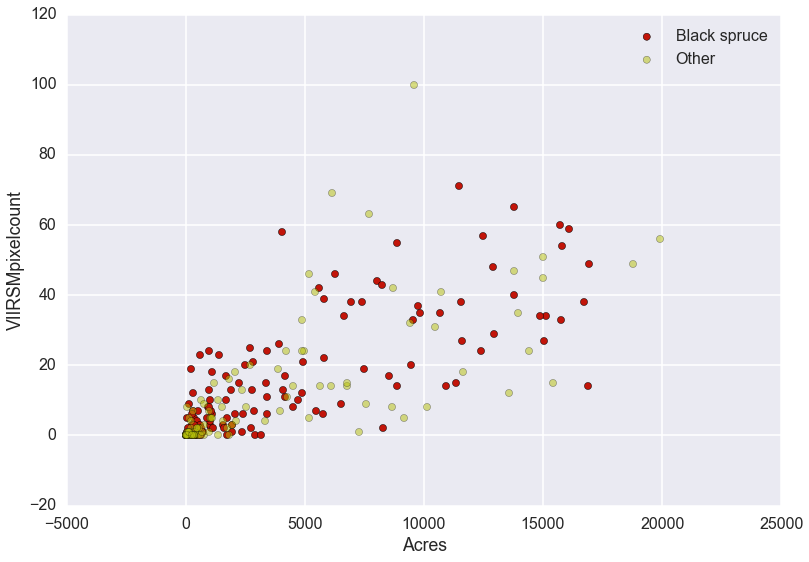

In [100]:
palette = itertools.cycle(sns.color_palette())
ax1 = cleanedfireperimDF[(cleanedfireperimDF.PRIMARYFUE == "Black Spruce") & (cleanedfireperimDF.Acres <= 20000 )].plot(kind='scatter', x='Acres', y="VIIRSMpixelcount", s=50, label="Black spruce", color=next(palette))
cleanedfireperimDF[(cleanedfireperimDF.PRIMARYFUE != "Black Spruce") & (cleanedfireperimDF.Acres <= 20000 )].plot(kind='scatter', x='Acres', y="VIIRSMpixelcount", ax=ax1, s=50, label="Other", color=next(palette), alpha=0.5)

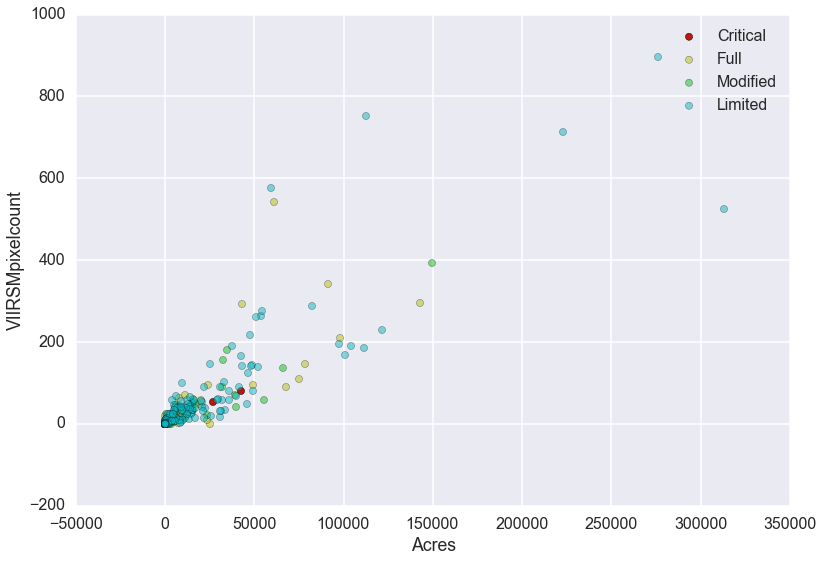

In [86]:
palette = itertools.cycle(sns.color_palette())
ax1 = cleanedfireperimDF[cleanedfireperimDF.MGMTOPTION == "Critical"].plot(kind='scatter', x='Acres', y="VIIRSMpixelcount", s=50, label="Critical", color=next(palette))
cleanedfireperimDF[cleanedfireperimDF.MGMTOPTION == "Full"].plot(kind='scatter', x='Acres', y="VIIRSMpixelcount", ax=ax1, s=50, label="Full", color=next(palette), alpha=0.5)
cleanedfireperimDF[cleanedfireperimDF.MGMTOPTION == "Modified"].plot(kind='scatter', x='Acres', y="VIIRSMpixelcount", ax=ax1, s=50, label="Modified", color=next(palette), alpha=0.5)
cleanedfireperimDF[cleanedfireperimDF.MGMTOPTION == "Limited"].plot(kind='scatter', x='Acres', y="VIIRSMpixelcount", ax=ax1, s=50, label="Limited", color=next(palette), alpha=0.5)


In [275]:
cleanedfireperimDF.groupby(["MGMTOPTION"])["VIIRSMcount"].mean()

MGMTOPTION
Critical      22.166667
Full          28.320000
Limited       43.797101
Modified      38.261905
Prescribed     0.000000
Name: VIIRSMcount, dtype: float64

In [87]:
cleanedfireperimDF.groupby(["MGMTOPTION"])["Acres"].mean()

MGMTOPTION
Critical      11613.550000
Full          13120.412162
Limited       16822.393204
Modified      15454.050000
Prescribed      686.000000
Name: Acres, dtype: float64

## Now VIIRS I-band

In [259]:
viirsIDF['infireperim'] = False
cleanedfireperimDF['VIIRSIcount'] = 0

In [260]:
for idx, record in cleanedfireperimDF.iterrows():
    timecomphelper = comparewithrow(record.DISCOVERYD, record.OUTDATE)
    buffered = record.geometry.buffer(1000)
    for pix, firepixel in viirsIDF[viirsIDF.apply(lambda row: timecomphelper(row), axis=1)].iterrows():
        if buffered.contains(firepixel.geometry):
            cleanedfireperimDF.loc[idx, 'VIIRSIcount'] += 1
            viirsIDF.loc[pix, 'infireperim'] = True
    print("{} - {} done".format(idx, record.FireName)) 

0 - Stuart Inert done
1 - CAL 1 done
2 - Bolgen Creek done
3 - Stuart Inert 2 done
4 - YTA Moose Creek RX 2015 done
5 - Little Montana Creek done
6 - Hickey Creek done
7 - Nikolai Slough done
8 - Machine done
9 - FWA Small Arms Complex RX 2015 done
10 - Little Swift Creek done
11 - DTAE Jarvis Creek RX 2015 done
12 - DTAE Wills SAC RX 2015 done
13 - Crater done
14 - North Fork done
15 - Sinona Creek done
16 - DMPTR 9 done
17 - Cal 4 done
18 - Kolmakof River done
19 - Sethkokna done
20 - West Fork done
21 - Bullion Creek done
22 - DTAE Bolio Lake Rx 2015 done
23 - Eagle Creek done
24 - DMPTR 7 done
25 - Black Lake done
26 - Ruby Slough done
27 - Little Creek done
28 - Red Devil done
29 - June Creek done
30 - Nushagak River done
31 - Juneau Lake done
32 - Yukon done
33 - Card Street done
34 - Apoon done
35 - Sockeye done
36 - Eldorado done
37 - Salmon River done
38 - Cummings Road done
39 - Stony done
40 - Buchahan done
41 - Copenhagen Creek done
42 - Kaghasuk Lake done
43 - Aropuk Lake 

In [262]:
cleanedfireperimDF.corr()

,Acres,AgencyAcre,AREA,ESTIMATEDT,LATITUDE,LONGITUDE,STRUCTURES,MOD14count,VIIRSMcount,VIIRSIcount
Acres,1.000000,0.010883,NaN,1.000000,0.146952,-0.065596,-0.000261,0.893578,0.895635,0.925758
AgencyAcre,0.010883,1.000000,NaN,0.010881,-0.026723,0.020999,0.100483,0.016325,0.007478,0.040720
AREA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ESTIMATEDT,1.000000,0.010881,NaN,1.000000,0.146926,-0.065558,-0.000260,0.893581,0.895636,0.925765
LATITUDE,0.146952,-0.026723,NaN,0.146926,1.000000,0.360729,-0.051310,0.227166,0.218221,0.196731
LONGITUDE,-0.065596,0.020999,NaN,-0.065558,0.360729,1.000000,0.044488,0.010226,-0.000797,0.003755
STRUCTURES,-0.000261,0.100483,NaN,-0.000260,-0.051310,0.044488,1.000000,0.005627,-0.013651,-0.000934
MOD14count,0.893578,0.016325,NaN,0.893581,0.227166,0.010226,0.005627,1.000000,0.976974,0.963767
VIIRSMcount,0.895635,0.007478,NaN,0.895636,0.218221,-0.000797,-0.013651,0.976974,1.000000,0.951844
VIIRSIcount,0.925758,0.040720,NaN,0.925765,0.196731,0.003755,-0.000934,0.963767,0.951844,1.000000


In [276]:
print("Number of undetected fires: {}".format(sum(cleanedfireperimDF.VIIRSIcount == 0)))
print(("Percentage of undetected fires: {:.2f}".format(100*sum(cleanedfireperimDF.VIIRSIcount == 0)/len(cleanedfireperimDF))))
print(("Acreage of largest undetected fire: {}".format(max(cleanedfireperimDF.Acres[cleanedfireperimDF.VIIRSIcount == 0]))))

Number of undetected fires: 75
Percentage of undetected fires: 22.46
Acreage of largest undetected fire: 3342.3


In [277]:
max(cleanedfireperimDF.VIIRSIcount)

3991

In [278]:
print(sum(viirsIDF.infireperim), sum(~viirsIDF.infireperim), sum(~viirsIDF.infireperim)/len(viirsIDF))

53084 1593 0.0291347367266


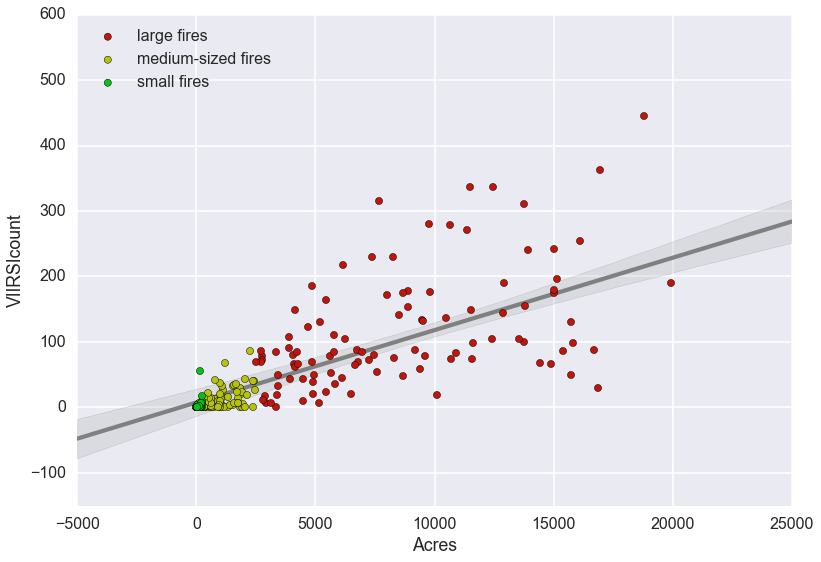

In [376]:
palette = itertools.cycle(sns.color_palette())
ax1 = cleanedfireperimDF_forstats[(cleanedfireperimDF.Acres > 2500) & (cleanedfireperimDF.Acres <= 20000 ) ].plot(
    kind='scatter', x='Acres', y="VIIRSIcount", s=50, 
    label="large fires", color=next(palette), zorder=2)
cleanedfireperimDF_forstats[(cleanedfireperimDF.Acres <= 2500) & (cleanedfireperimDF.Acres > 250) ].plot(
    kind='scatter', x='Acres', y="VIIRSIcount", ax=ax1, s=50, label="medium-sized fires", 
    color=next(palette), zorder=3)
cleanedfireperimDF_forstats[(cleanedfireperimDF.Acres <= 250) ].plot(
    kind='scatter', x='Acres', y="VIIRSIcount", s=50, 
    label="small fires", color=next(palette), ax=ax1, zorder=4)
palette = itertools.cycle(sns.color_palette())
sns.regplot(
    x="Acres", 
    y="VIIRSIcount", 
    data=cleanedfireperimDF,
    ax=ax1,
    color='grey',
    scatter=False,
    line_kws={'zorder': 1}
    )
#sns.regplot(
#    x="Acres", 
#    y="VIIRSIcount", 
#    data=cleanedfireperimDF.loc[(cleanedfireperimDF.Acres <= 2500) & (cleanedfireperimDF.Acres > 250)],
#    ax=ax1,
#    color=next(palette),
#    scatter=False,
#    line_kws={'zorder': 1}
#    )
#sns.regplot(
#    x="Acres", 
#    y="VIIRSIcount", 
#    data=cleanedfireperimDF.loc[cleanedfireperimDF.Acres <= 250],
#    ax=ax1,
#    color=next(palette),
#    scatter=False,
#    line_kws={'zorder': 1}
#    )
ax1.set_ylim((-150, 600))
ax1.legend(loc="upper left")

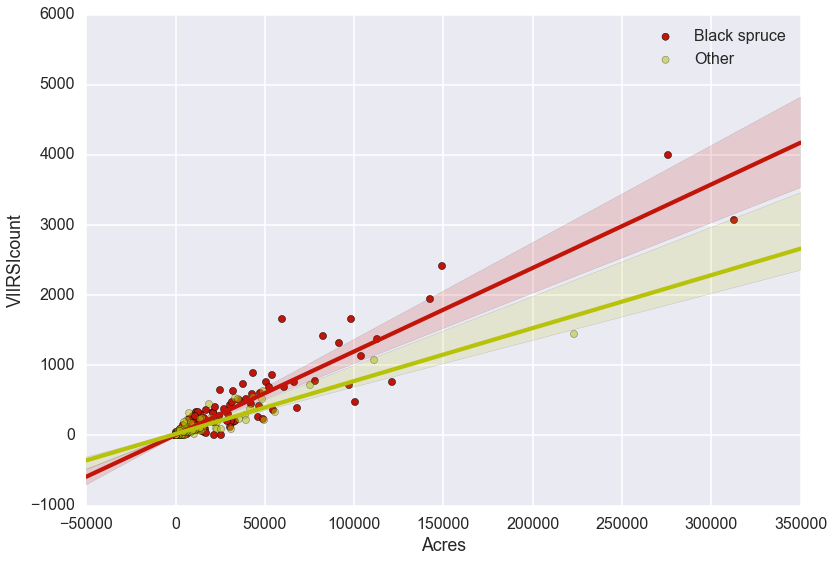

In [372]:
palette = itertools.cycle(sns.color_palette())
ax1 = cleanedfireperimDF_forstats[cleanedfireperimDF.PRIMARYFUE == "Black Spruce"].plot(
    kind='scatter', x='Acres', y="VIIRSIcount", s=50, label="Black spruce", color=next(palette))
cleanedfireperimDF_forstats[cleanedfireperimDF.PRIMARYFUE != "Black Spruce"].plot(
    kind='scatter', x='Acres', y="VIIRSIcount", ax=ax1, s=50, label="Other", color=next(palette), alpha=0.5)

palette = itertools.cycle(sns.color_palette())
sns.regplot(
    x="Acres", 
    y="VIIRSIcount", 
    data=cleanedfireperimDF.loc[cleanedfireperimDF.blacksprucefire],
    ax=ax1,
    color=next(palette),
    scatter=False,
    line_kws={'zorder': 1}
    )
sns.regplot(
    x="Acres", 
    y="VIIRSIcount", 
    data=cleanedfireperimDF.loc[~cleanedfireperimDF.blacksprucefire],
    ax=ax1,
    color=next(palette),
    scatter=False,
    line_kws={'zorder': 1}
    )

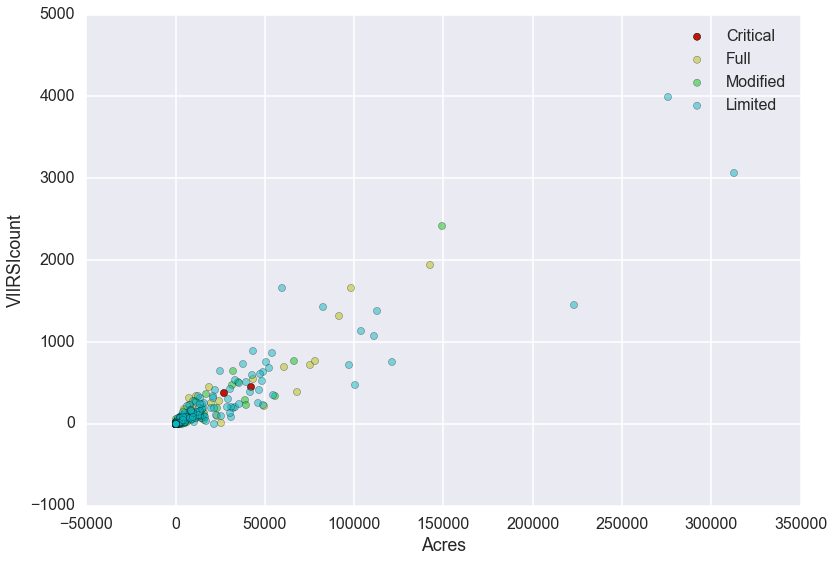

In [309]:
palette = itertools.cycle(sns.color_palette())
ax1 = cleanedfireperimDF[cleanedfireperimDF.MGMTOPTION == "Critical"][['Acres', 'VIIRSIcount']].plot(kind='scatter', x='Acres', y="VIIRSIcount", s=50, label="Critical", color=next(palette))
cleanedfireperimDF[cleanedfireperimDF.MGMTOPTION == "Full"][['Acres', 'VIIRSIcount']].plot(kind='scatter', x='Acres', y="VIIRSIcount", ax=ax1, s=50, label="Full", color=next(palette), alpha=0.5)
cleanedfireperimDF[cleanedfireperimDF.MGMTOPTION == "Modified"][['Acres', 'VIIRSIcount']].plot(kind='scatter', x='Acres', y="VIIRSIcount", ax=ax1, s=50, label="Modified", color=next(palette), alpha=0.5)
cleanedfireperimDF[cleanedfireperimDF.MGMTOPTION == "Limited"][['Acres', 'VIIRSIcount']].plot(kind='scatter', x='Acres', y="VIIRSIcount", ax=ax1, s=50, label="Limited", color=next(palette), alpha=0.5)


## Preparing for further data analysis

Let's make a column that indicates black spruce vs. non black spruce fueled fires.

In [65]:
cleanedfireperimDF['blacksprucefire'] = cleanedfireperimDF['PRIMARYFUE'] == "Black Spruce"

## Data inspection for badly detected fires etc.

In [66]:
displayperimcols = [
    u'Acres', u'Date', u'FireName', 'cleanedID', u'CONTROLDAT', 
    u'DISCOVERYD', u'FIREBEHAVI', u'GENERALCAU', u'LATITUDE', 
    u'LONGITUDE', u'MGMTOPTION', u'OUTDATE', u'PRIMARYFUE', u'STRUCTURES', 'blacksprucefire',
    'MOD14count', 'VIIRSIcount']

In [67]:
cleanedfireperimDF[
    (cleanedfireperimDF.VIIRSIcount <10)
    #& (cleanedfireperimDF.MOD14count == 0)
    ].sort_values(
        by='Acres', ascending=False
        ).head(15)[displayperimcols]

,Acres,Date,FireName,cleanedID,CONTROLDAT,DISCOVERYD,FIREBEHAVI,GENERALCAU,LATITUDE,LONGITUDE,MGMTOPTION,OUTDATE,PRIMARYFUE,STRUCTURES,blacksprucefire,MOD14count,VIIRSIcount
64,25259.8,2015-06-07,Bogus Creek,JRD3,2015/09/21,2015/05/31,None,Lightning,61.205166,-160.336500,Full,2015/09/21,Black Spruce,2,True,54,7
154,21698.0,2015-07-27,Mingvk Lake,JY50,2015/09/28,2015/07/19,Running,Lightning,65.416666,-164.533333,Limited,2015/09/28,Black Spruce,0,True,11,2
41,5166.7,2015-07-04,Copenhagen Creek,JT2A,2015/08/26,2015/06/22,None,Lightning,58.841000,-157.543166,Modified,2015/08/26,Grass,0,False,9,7
103,3342.3,2015-07-11,Copenhagen,JW07,2015/08/26,2015/07/04,None,Lightning,58.903638,-157.404611,Modified,2015/08/26,Other,0,False,0,0
241,3141.5,2015-07-10,Beaver Creek,504661,2015/08/26,2015/06/26,None,Lightning,63.125611,-156.686194,Modified,2015/08/26,Black Spruce,0,True,3,7
54,2902.3,2015-06-03,Seventymile,JQ2N,2015/08/15,2015/05/24,Smoldering,Lightning,64.900000,-141.383333,Full,2015/08/15,Black Spruce,0,True,44,7
289,2362.6,2015-08-11,Bear Island Lake,JX1M,2015/09/21,2015/07/11,None,Lightning,63.490333,-153.344333,Full,2015/09/21,Black Spruce,0,True,4,1
195,2060.1,2015-08-04,Little Black,JWY7,2015/10/05,2015/07/05,Creeping,Lightning,65.700000,-143.233333,Limited,2015/10/05,Black Spruce,0,True,0,0
132,1949.4,2015-09-01,Foraker,JW3N,2015/08/25,2015/07/06,Creeping,Lightning,63.639583,-152.109111,Limited,2015/08/25,Black Spruce,0,True,17,5
81,1930.0,2015-07-11,Little Kokwok,504727,2015/08/12,2015/07/10,None,Lightning,59.553611,-158.359722,Full,2015/08/12,Mixed (Hardwoods/Softwoods),0,False,2,0


In [396]:
cleanedfireperimDF[
    (cleanedfireperimDF.VIIRSIcount < 50) 
    & (cleanedfireperimDF.Acres > 10000)
#    & (cleanedfireperimDF.MOD14count > 10)
    ][displayperimcols]

,Acres,Date,FireName,cleanedID,CONTROLDAT,DISCOVERYD,FIREBEHAVI,GENERALCAU,LATITUDE,LONGITUDE,MGMTOPTION,OUTDATE,PRIMARYFUE,STRUCTURES,blacksprucefire,MOD14count,VIIRSIcount
37,15740.4,2015-09-18,Salmon River,JZ1M,2015/09/10,2015/07/23,Running,Lightning,67.158333,-159.307500,Modified,2015/09/10,Black Spruce,0,True,57,49
64,25259.8,2015-06-07,Bogus Creek,JRD3,2015/09/21,2015/05/31,None,Lightning,61.205166,-160.336500,Full,2015/09/21,Black Spruce,2,True,54,7
154,21698.0,2015-07-27,Mingvk Lake,JY50,2015/09/28,2015/07/19,Running,Lightning,65.416666,-164.533333,Limited,2015/09/28,Black Spruce,0,True,11,2
183,10109.2,2015-07-30,Wapoo,JUU0,2015/08/21,2015/06/26,Running,Lightning,63.680000,-157.883000,Limited,2015/08/21,Other,0,False,21,19
311,16869.2,2015-07-21,Poorman Creek,JUT6,2015/09/28,2015/06/26,Running,Lightning,63.977500,-155.931833,Limited,2015/09/28,Black Spruce,0,True,23,29


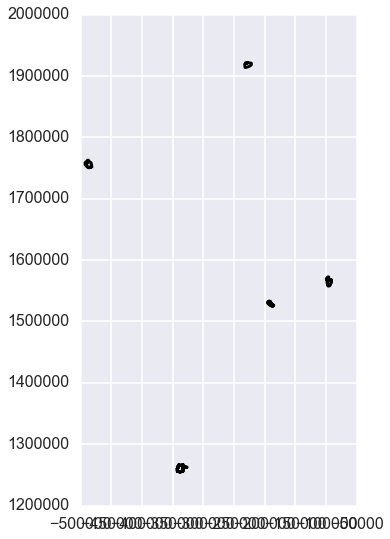

In [398]:
cleanedfireperimDF[
    (cleanedfireperimDF.VIIRSIcount < 50) 
    & (cleanedfireperimDF.Acres > 10000)
#    & (cleanedfireperimDF.MOD14count > 10)
    ].plot()

In [107]:
cleanedfireperimDF.groupby(["MGMTOPTION"])["VIIRSIpixelcount"].mean()

MGMTOPTION
Critical      138.500000
Full          164.391892
Limited       193.762136
Modified      197.750000
Prescribed      0.250000
Name: VIIRSIpixelcount, dtype: float64

In [389]:
cleanedfireperimDF[(cleanedfireperimDF.LATITUDE < 65.771) & (cleanedfireperimDF.LATITUDE > 64.85)
        & (cleanedfireperimDF.LONGITUDE < -141.2) & (cleanedfireperimDF.LONGITUDE > -143.3)][displayperimcols]

,Acres,Date,FireName,cleanedID,CONTROLDAT,DISCOVERYD,FIREBEHAVI,GENERALCAU,LATITUDE,LONGITUDE,MGMTOPTION,OUTDATE,PRIMARYFUE,STRUCTURES,blacksprucefire,MOD14count,VIIRSIcount
54,2902.3,2015-06-03,Seventymile,JQ2N,2015/08/15,2015/05/24,Smoldering,Lightning,64.900000,-141.383333,Full,2015/08/15,Black Spruce,0,True,44,7
87,118.2,2015-07-11,Suter Creek,JX1L,2015/08/03,2015/07/11,Creeping,Lightning,64.931222,-142.169111,Limited,2015/08/03,Black Spruce,0,True,1,0
195,2060.1,2015-08-04,Little Black,JWY7,2015/10/05,2015/07/05,Creeping,Lightning,65.700000,-143.233333,Limited,2015/10/05,Black Spruce,0,True,0,0
314,7.0,2015-07-26,Weshrinarin Creek,JX5V,2015/08/03,2015/07/13,Creeping,Lightning,65.263888,-142.621416,Limited,2015/08/03,Black Spruce,0,True,0,0
324,263.6,2015-07-24,Trout,JQ2T,2015/10/05,2015/05/24,Creeping,Lightning,65.102000,-141.634833,Limited,2015/10/05,Unknown,2,False,1,2


In [108]:
cleanedfireperimDF[cleanedfireperimDF.FireName.str.startswith("Sockeye")]

,Acres,AgencyAcre,Date,FireName,geometry,cleanedID,AREA,CONTROLDAT,DISCOVERYD,ESTIMATEDT,...,LATITUDE,LONGITUDE,MGMTOPTION,NAME,OUTDATE,PRIMARYFUE,STRUCTURES,MOD14pixelcount,VIIRSMpixelcount,VIIRSIpixelcount
35,7264.9,7264.8,2015-07-04,Sockeye,(POLYGON ((203012.3694389864 1317671.666836289...,JSM8,0,2015/07/22,2015/06/14,7264.9,...,61.844861,-150.085444,Full,Sockeye,2015/10/01,Mixed (Hardwoods/Softwoods),1455,48,1,73


In [68]:
cleanedfireperimDF.columns


Index([      u'AFSNUMBER',            u'AREA',           u'Acres',
            u'AgencyAcre',      u'CONTROLDAT',      u'DISCOVERYD',
             u'DOFNUMBER',            u'Date',      u'ESTIMATEDT',
            u'FALSEALARM',      u'FIREBEHAVI',        u'FireName',
            u'GENERALCAU',        u'LATITUDE',       u'LONGITUDE',
            u'MGMTOPTION',      u'MOD14count',            u'NAME',
               u'OUTDATE',      u'PRIMARYFUE',      u'STRUCTURES',
            u'USFSNUMBER',     u'VIIRSIcount',     u'VIIRSMcount',
             u'cleanedID',        u'geometry', u'blacksprucefire'],
      dtype='object')

In [69]:
cleanedfireperimDF[['Acres', 'MOD14count', 'VIIRSMcount', 'VIIRSIcount', 'LATITUDE', 'LONGITUDE']].corr()

,Acres,MOD14count,VIIRSMcount,VIIRSIcount,LATITUDE,LONGITUDE
Acres,1.000000,0.893578,0.895635,0.925758,0.146952,-0.065596
MOD14count,0.893578,1.000000,0.976974,0.963767,0.227166,0.010226
VIIRSMcount,0.895635,0.976974,1.000000,0.951844,0.218221,-0.000797
VIIRSIcount,0.925758,0.963767,0.951844,1.000000,0.196731,0.003755
LATITUDE,0.146952,0.227166,0.218221,0.196731,1.000000,0.360729
LONGITUDE,-0.065596,0.010226,-0.000797,0.003755,0.360729,1.000000


In [70]:
cleanedfireperimDF.blacksprucefire.value_counts()

True     204
False    130
Name: blacksprucefire, dtype: int64

### Save cleaned fire perimeter dataset

In [79]:
outdir = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/GISout/"
cleanedfireperimDF.to_file(os.path.join(outdir, "cleanedFirePerimsWithFirepoints20160228.shp"), driver="ESRI Shapefile")

ValueError: 'bool' is not in list

### Statistics! 

In [63]:
import numpy as np
import statsmodels.formula.api as smf
from pandas.tools.plotting import plot_frame

Somehow Pandas-style plotting doesn't work on GeoPandas GeoDataFrames. Until I find a better solution, I'm makeing a copy that's just a regular dataframe:

In [64]:
keepperimcols = list(cleanedfireperimDF.columns)
keepperimcols.remove('geometry')
cleanedfireperimDF_forstats = cleanedfireperimDF[keepperimcols].copy()
type(cleanedfireperimDF_forstats)

pandas.core.frame.DataFrame

In [71]:
results = smf.ols('VIIRSIcount ~ MOD14count', cleanedfireperimDF).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:            VIIRSIcount   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     4334.
Date:                Tue, 01 Mar 2016   Prob (F-statistic):          1.32e-192
Time:                        13:21:05   Log-Likelihood:                -2039.1
No. Observations:                 334   AIC:                             4082.
Df Residuals:                     332   BIC:                             4090.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.9779      6.555     -0.454      0.6

In [72]:
results = smf.ols('MOD14count ~ Acres', cleanedfireperimDF.loc[cleanedfireperimDF['blacksprucefire']]).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:             MOD14count   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     803.2
Date:                Tue, 01 Mar 2016   Prob (F-statistic):           2.56e-72
Time:                        13:21:12   Log-Likelihood:                -1222.2
No. Observations:                 204   AIC:                             2448.
Df Residuals:                     202   BIC:                             2455.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     12.6442      7.543      1.676      0.0

In [73]:
results = smf.ols('VIIRSIcount ~ Acres', cleanedfireperimDF.loc[cleanedfireperimDF['blacksprucefire']]).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:            VIIRSIcount   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     1498.
Date:                Tue, 01 Mar 2016   Prob (F-statistic):           2.25e-95
Time:                        13:21:14   Log-Likelihood:                -1335.1
No. Observations:                 204   AIC:                             2674.
Df Residuals:                     202   BIC:                             2681.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.1650     13.122      0.546      0.5

In [74]:
results.params

Intercept    7.164995
Acres        0.011905
dtype: float64

In [75]:
results = smf.ols('VIIRSIcount ~ MOD14count', cleanedfireperimDF).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:            VIIRSIcount   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     4334.
Date:                Tue, 01 Mar 2016   Prob (F-statistic):          1.32e-192
Time:                        13:21:19   Log-Likelihood:                -2039.1
No. Observations:                 334   AIC:                             4082.
Df Residuals:                     332   BIC:                             4090.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.9779      6.555     -0.454      0.6

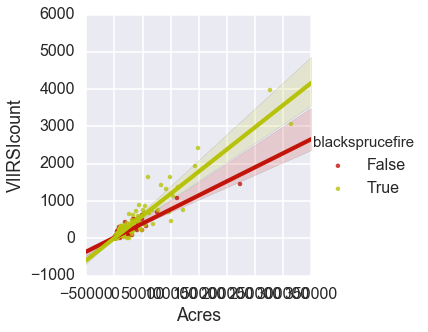

In [76]:
sns.lmplot(x="Acres", y="VIIRSIcount", hue="blacksprucefire", data=cleanedfireperimDF);

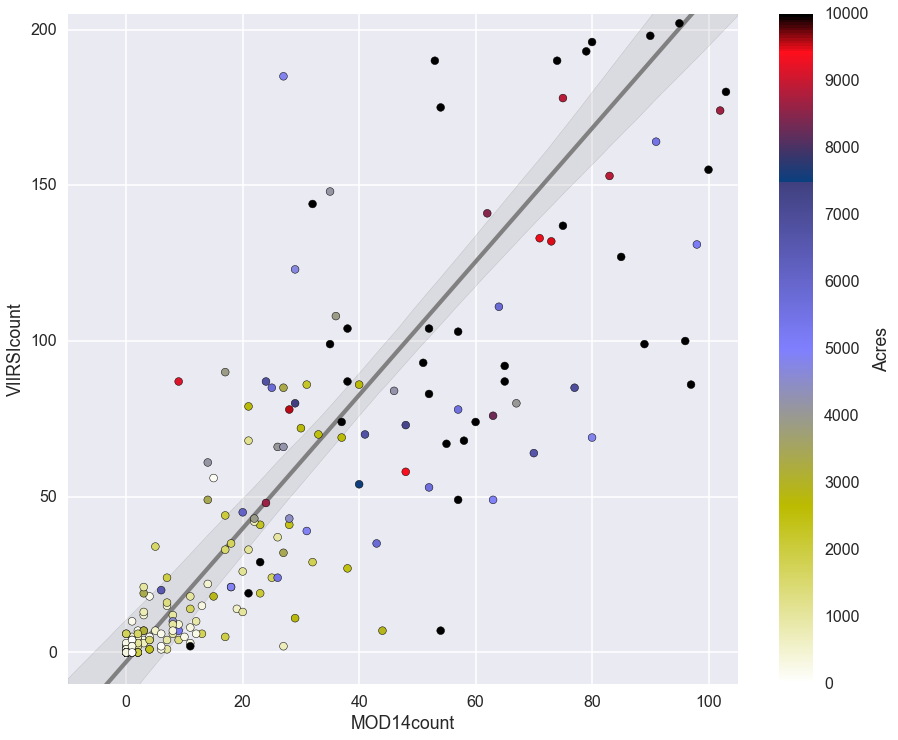

In [77]:
palette = itertools.cycle(sns.color_palette())
xlim = (-10, 105)
ylim = (-10, 205)
ax1 = plot_frame(cleanedfireperimDF, kind='scatter', 
                                 x="MOD14count", 
                                 y="VIIRSIcount", 
                                 xlim=xlim, 
                                 ylim=ylim, 
                                 s=60, 
                                 c='Acres',
                                 cmap="gist_stern_r",
                                 vmin=0, 
                                 vmax=10000,
                                 colorbar=True,
                                 legend=True,
                                 figsize=(15, 12),
                                 sharex=False,
                                 zorder=2
                                )
sns.regplot(
    x="MOD14count", 
    y="VIIRSIcount", 
    data=cleanedfireperimDF,
    ax=ax1,
    color="grey",
    scatter=False,
    line_kws={'zorder': 1}
    )

#ax1.set_aspect("equal")
f = plt.gcf()
#f.subplots_adjust(bottom=0.4)
#x = np.array([xlim[0], xlim[1]])
#y = intercept + slope * x
#plt.plot(x, y, 'r-', color=next(palette))

f.savefig('/Users/cwaigl/Desktop/samplefigure_close')

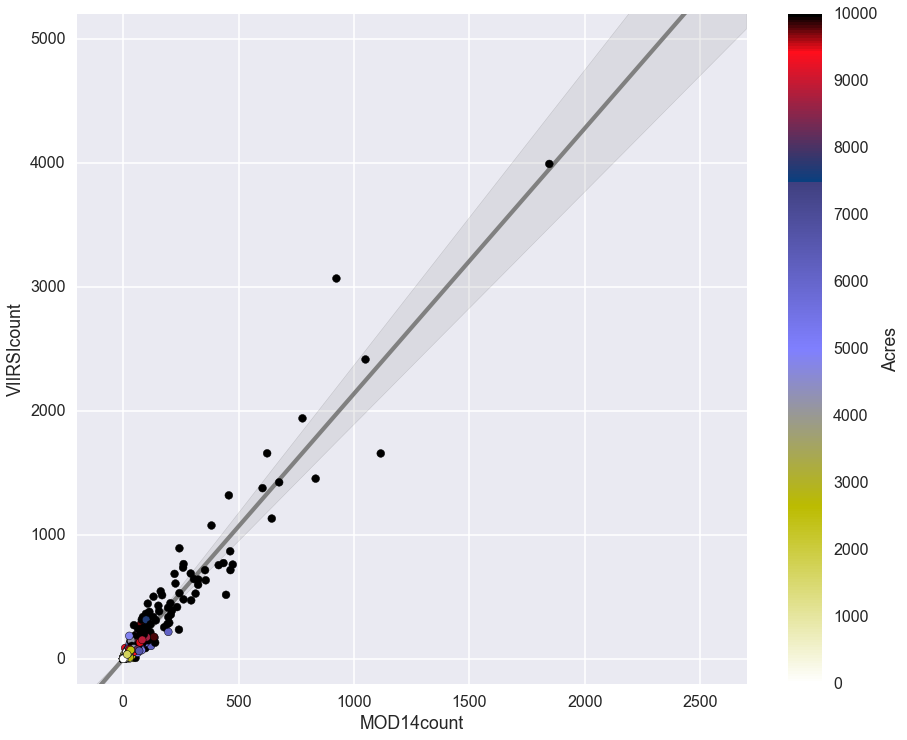

In [294]:
palette = itertools.cycle(sns.color_palette())
xlim = (-200, 2700)
ylim = (-200, 5200)
ax1 = cleanedfireperimDF_forstats.plot(kind='scatter', 
                                 x="MOD14count", 
                                 y="VIIRSIcount", 
                                 xlim=xlim, 
                                 ylim=ylim, 
                                 s=60, 
                                 c='Acres',
                                 cmap="gist_stern_r",
                                 vmin=0, 
                                 vmax=10000,
                                 colorbar=True,
                                 legend=True,
                                 figsize=(15, 12),
                                 sharex=False,
                                 zorder=2
                                )
#x = np.array([xlim[0], xlim[1]])
#y = intercept + slope * x
#plt.plot(x, y, 'r-', color=next(palette))
sns.regplot(
    x="MOD14count", 
    y="VIIRSIcount", 
    data=cleanedfireperimDF,
    ax=ax1,
    color="grey",
    scatter=False,
    line_kws={'zorder': 1}
    )
f = plt.gcf()
f.savefig('/Users/cwaigl/Desktop/samplefigure')

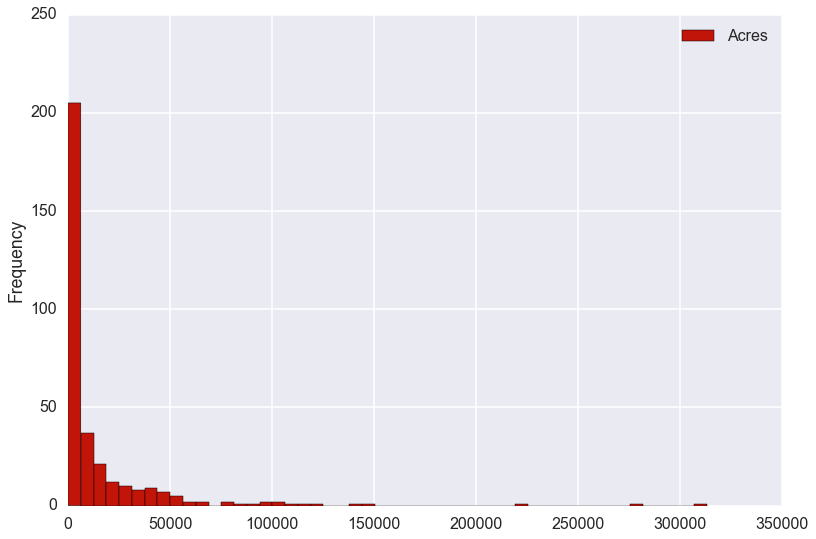

In [299]:
ax1 = cleanedfireperimDF["Acres"].plot(kind='hist', bins=50, legend=True)

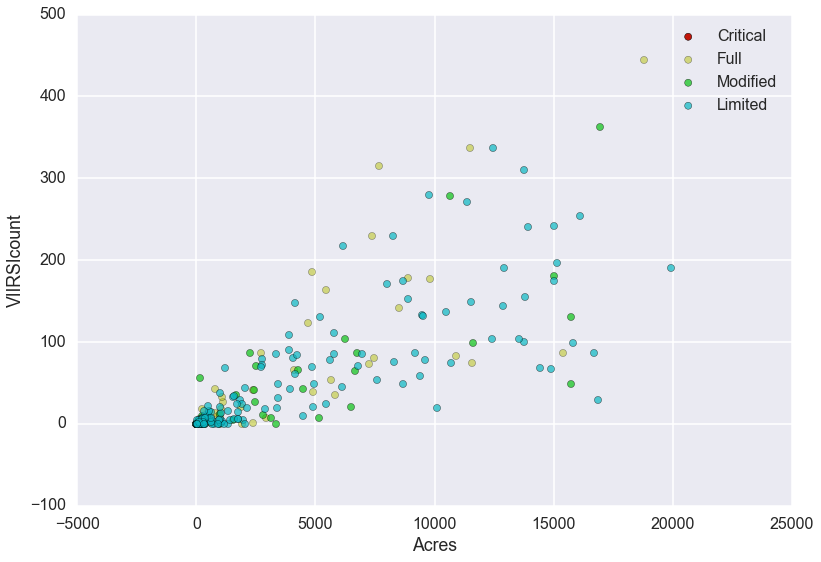

In [353]:
palette = itertools.cycle(sns.color_palette())
ax1 = cleanedfireperimDF[
    (cleanedfireperimDF.MGMTOPTION == "Critical")& (cleanedfireperimDF.Acres <= 20000 )
    ][['Acres', 'VIIRSIcount']].plot(
    kind='scatter', x='Acres', y="VIIRSIcount", s=50, label="Critical", color=next(palette))
cleanedfireperimDF_forstats[
    (cleanedfireperimDF.MGMTOPTION == "Full")& (cleanedfireperimDF.Acres <= 20000 )
    ][['Acres', 'VIIRSIcount']].plot(
    kind='scatter', x='Acres', y="VIIRSIcount", ax=ax1, s=50, label="Full", color=next(palette), alpha=0.5)
cleanedfireperimDF_forstats[
    (cleanedfireperimDF.MGMTOPTION == "Modified")& (cleanedfireperimDF.Acres <= 20000 )
    ][['Acres', 'VIIRSIcount']].plot(
    kind='scatter', x='Acres', y="VIIRSIcount", ax=ax1, s=50, label="Modified", color=next(palette), alpha=0.7)
cleanedfireperimDF_forstats[
    (cleanedfireperimDF.MGMTOPTION == "Limited") & (cleanedfireperimDF.Acres <= 20000 )
    ][['Acres', 'VIIRSIcount']].plot(kind='scatter', x='Acres', y="VIIRSIcount", ax=ax1, s=50, label="Limited", color=next(palette), alpha=0.7)



In [ ]:
palette = itertools.cycle(sns.color_palette())
ax1 = plot_frame(cleanedfireperimDF[cleanedfireperimDF.PRIMARYFUE == "Black Spruce"], kind='scatter', x='Acres', y="VIIRSIcount", s=50, label="Black spruce", color=next(palette))
cleanedfireperimDF[cleanedfireperimDF.PRIMARYFUE != "Black Spruce"].plot(kind='scatter', x='Acres', y="VIIRSIcount", ax=ax1, s=50, label="Other", color=next(palette), alpha=0.5)

In [302]:
cleanedfireperimDF["Acres"].describe()

count       334.000000
mean      15409.942814
std       34115.369953
min           0.100000
25%         289.900000
50%        2788.700000
75%       14764.300000
max      312918.200000
Name: Acres, dtype: float64

### Reload saved dataframe from file

In [57]:
import geopandas as gp

In [58]:
datadir = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/GISout/"
cleanedfireperimDF_loaded = gp.GeoDataFrame.from_file(os.path.join(datadir, "cleanedFirePerimsWithFirepoints20160228.json"))

In [59]:
cleanedfireperimDF_loaded.describe()

,AREA,Acres,AgencyAcre,ESTIMATEDT,LATITUDE,LONGITUDE,MOD14count,STRUCTURES,VIIRSIcount,VIIRSMcount
count,334,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,0,15409.942814,687.076347,15410.230240,63.748426,-153.817675,84.452096,5.979042,177.823353,38.712575
std,0,34115.369953,3423.476683,34115.114533,1.858928,5.456694,183.301002,81.774003,407.177639,88.022800
min,0,0.100000,0.000000,0.400000,57.615777,-165.130527,0.000000,0.000000,0.000000,0.000000
25%,0,289.900000,0.000000,301.075000,62.739340,-157.817458,1.000000,0.000000,1.000000,0.000000
50%,0,2788.700000,0.000000,2788.600000,64.015999,-154.601860,21.000000,0.000000,33.000000,8.500000
75%,0,14764.300000,0.725000,14764.300000,64.983333,-150.312812,82.500000,0.000000,176.500000,35.000000
max,0,312918.200000,41514.100000,312918.200000,67.916000,-141.026388,1846.000000,1455.000000,3991.000000,896.000000


In [60]:
cleanedfireperimDF = cleanedfireperimDF_loaded

In [61]:
cleanedfireperimDF.columns

Index([  u'AFSNUMBER',        u'AREA',       u'Acres',  u'AgencyAcre',
        u'CONTROLDAT',  u'DISCOVERYD',   u'DOFNUMBER',        u'Date',
        u'ESTIMATEDT',  u'FALSEALARM',  u'FIREBEHAVI',    u'FireName',
        u'GENERALCAU',    u'LATITUDE',   u'LONGITUDE',  u'MGMTOPTION',
        u'MOD14count',        u'NAME',     u'OUTDATE',  u'PRIMARYFUE',
        u'STRUCTURES',  u'USFSNUMBER', u'VIIRSIcount', u'VIIRSMcount',
         u'cleanedID',    u'geometry'],
      dtype='object')

In [65]:
print(len(cleanedfireperimDF), len(cleanedfireperimDF_loaded))

334 334


### Further exploratory code snippets

In [326]:
cleanedfireperimDF_loaded[cleanedfireperimDF_loaded.AREA.isnull()][['FireName', 'cleanedID', 'Acres', 'VIIRSIcount']]

,FireName,cleanedID,Acres,VIIRSIcount


In [158]:
fireeventDF[fireeventDF.NAME.isin(['Stony', 'North Fork Flats', 'Quartz Creek', 'Scow Harry # 2'])][['NAME', 'cleanedID', 'USFSNUMBER', 'AFSNUMBER', 'DOFNUMBER', 'AREA']]

,NAME,cleanedID,USFSNUMBER,AFSNUMBER,DOFNUMBER,AREA
433,Quartz Creek,504434,None,JZ8G,504434,0
600,North Fork Flats,504607,None,J4Y6,504607,0
606,Scow Harry # 2,504614,PNJY2T,JY2T,504614,0
623,Stony,504472,None,J0G0,504472,0


In [159]:
fireperimDF[fireperimDF.FireName.isin(['Stony', 'North Fork Flats', 'Quartz Creek', 'Scow Harry # 2.'])][['FireName', 'USFSFire#', 'AFSFire#', 'DOFFire#', 'Acres', 'geometry']]

,FireName,USFSFire#,AFSFire#,DOFFire#,Acres,geometry
39,Stony,None,None,504472,232.5,POLYGON ((-119861.1075106363 1297773.115574771...
48,North Fork Flats,None,None,504607,15402.8,(POLYGON ((1101.605629159798 1473955.965618643...
137,Quartz Creek,None,None,504434,125.1,POLYGON ((-336391.5594960534 1191201.757936117...
308,Scow Harry # 2.,None,None,504614,4249.7,POLYGON ((-22908.27588810034 1480419.970181071...


In [160]:
for (item) in fireperimDF[fireperimDF.FireName.isin(['North Fork Flats'])].geometry:
    for poly in item:
        print(poly.area)
    

62298945.5818
25922.5744042
8062.95701915


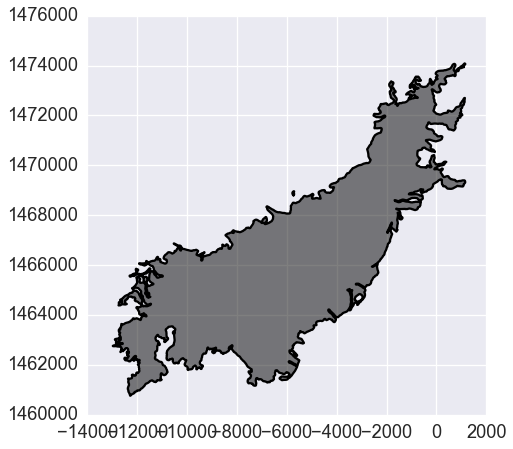

In [115]:
fireperimDF[fireperimDF.FireName.isin(['North Fork Flats'])].plot(alpha=0.5)

In [130]:
cleanedfireperimDF_loaded[cleanedfireperimDF_loaded.FireName.isin(['Sushgitit Hills', 'Rock', 'Isahultila', 'Big Mud River 1'])][['FireName', 'VIIRSIpixelcount', 'MOD14pixelcount']]

,FireName,VIIRSIpixelcount,MOD14pixelcount
133,Rock,1939,777
134,Sushgitit Hills,3991,1846
222,Isahultila,2414,1050
226,Big Mud River 1,1131,644
